<a href="https://colab.research.google.com/github/Alemzhan-A/ML_FashionMNIST_Yandex/blob/main/Fashion_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задание 1:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchsummary import summary
from sklearn import metrics

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=transforms.Compose([transforms.ToTensor()]))
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=transforms.Compose([transforms.ToTensor()]))

train_loader = DataLoader(train_set, batch_size=100)
test_loader = DataLoader(train_set, batch_size=100)

In [ ]:
a = next(iter(train_loader))
a[0].size()

torch.Size([100, 1, 28, 28])

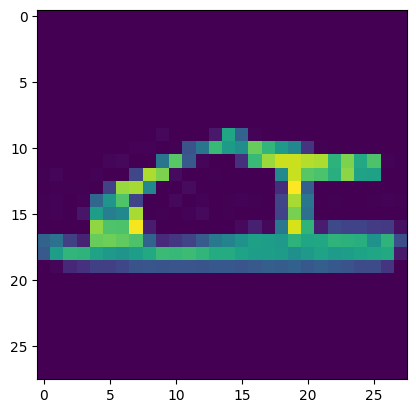

In [ ]:
plt.imshow(train_set[120][0].numpy()[0])

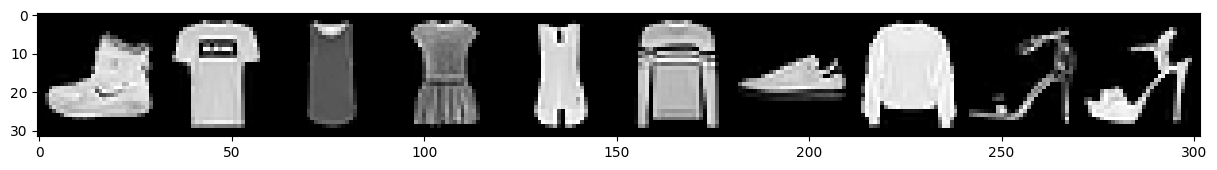

In [ ]:
demo_loader = torch.utils.data.DataLoader(train_set, batch_size=10)

batch = next(iter(demo_loader))
images, labels = batch
grid = torchvision.utils.make_grid(images, nrow=10)
plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))


In [ ]:
class MnistModel(nn.Module):
    def __init__(self):
        super(MnistModel, self).__init__()
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(28*28, 256)
        self.batch_norm1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.3)
        self.linear2 = nn.Linear(256, 128)
        self.batch_norm2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.3)
        self.linear3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = F.leaky_relu(self.batch_norm1(self.linear1(x)))
        x = self.dropout1(x)
        x = F.leaky_relu(self.batch_norm2(self.linear2(x)))
        x = self.dropout2(x)
        x = self.linear3(x)
        return x
model = MnistModel()


In [ ]:
model.to('cuda')
summary(model,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 256]         200,960
       BatchNorm1d-3                  [-1, 256]             512
           Dropout-4                  [-1, 256]               0
            Linear-5                  [-1, 128]          32,896
       BatchNorm1d-6                  [-1, 128]             256
           Dropout-7                  [-1, 128]               0
            Linear-8                   [-1, 10]           1,290
Total params: 235,914
Trainable params: 235,914
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.90
Estimated Total Size (MB): 0.92
----------------------------------------------------------------


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
BATCH_SIZE = 100
NUM_EPOCHS = 100

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE)

steps = 0
print_every = 200
train_loss_epoch = []
test_loss_epoch = []
accuracy_epoch = []
preds_hist = []
labels_hist = []
device = 'cpu'

for e in range(NUM_EPOCHS):
    model.train()
    running_loss = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        preds = model(images.to(device))
        loss = loss_fn(preds, labels.to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_train_loss = running_loss / len(train_loader)
    train_loss_epoch.append(epoch_train_loss)

    model.eval()
    running_accuracy = 0
    running_test_loss = 0
    with torch.no_grad():
        for images, labels in test_loader:
            preds = model(images.to(device))
            test_loss = loss_fn(preds, labels.to(device))
            running_test_loss += test_loss.item()
            labels_hist.extend(np.squeeze(labels.numpy()))
            ps = torch.exp(preds)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape).to(device)
            preds_hist.extend(np.squeeze(top_class.numpy()))
            running_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

    epoch_test_loss = running_test_loss / len(test_loader)
    epoch_accuracy = running_accuracy / len(test_loader)

    test_loss_epoch.append(epoch_test_loss)
    accuracy_epoch.append(epoch_accuracy)

    print(f"Epoch: {e+1}/{NUM_EPOCHS}.. "
          f"Training Loss: {epoch_train_loss:.3f}.. "
          f"Test Loss: {epoch_test_loss:.3f}.. "
          f"Test Accuracy: {epoch_accuracy:.3f}")
    print(metrics.classification_report(preds_hist,labels_hist))

Epoch: 1/100.. Training Loss: 0.527.. Test Loss: 0.415.. Test Accuracy: 0.850
              precision    recall  f1-score   support

           0       0.79      0.84      0.82       936
           1       0.94      0.99      0.97       950
           2       0.66      0.83      0.73       801
           3       0.88      0.86      0.87      1016
           4       0.78      0.74      0.76      1053
           5       0.88      0.97      0.92       913
           6       0.70      0.59      0.64      1196
           7       0.92      0.90      0.91      1023
           8       0.97      0.94      0.95      1040
           9       0.96      0.90      0.93      1072

    accuracy                           0.85     10000
   macro avg       0.85      0.86      0.85     10000
weighted avg       0.85      0.85      0.85     10000

Epoch: 2/100.. Training Loss: 0.391.. Test Loss: 0.377.. Test Accuracy: 0.861
              precision    recall  f1-score   support

           0       0.79      0

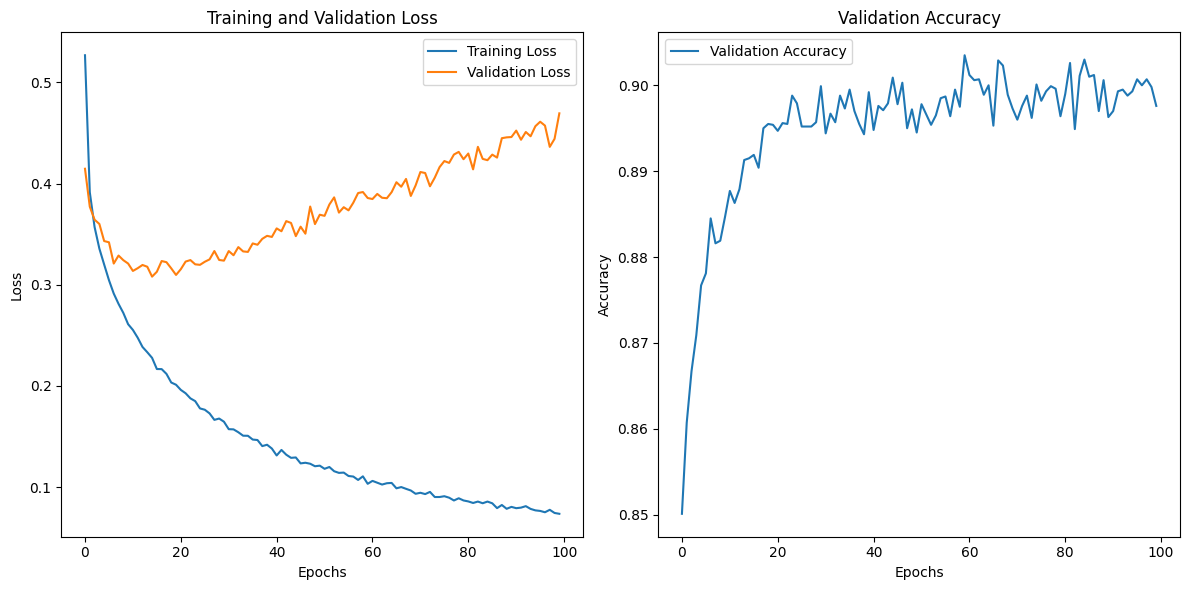

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_loss_epoch, label='Training Loss')
plt.plot(test_loss_epoch, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracy_epoch, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Вывод: Если судить по метрике accuracy и loss, то данная модель справляется с задачей нормально, так как accuracy имеет значение приблизительно 90%. Это значение является относительно хорошим для задач классификации. Думаю это не идеальный результат, потому что его можно улучшить с помощью добавления сверток и тд. Кроме этого, данная модель переобучилась. Далее посмотрим как свертки повлияют на это

# Задание 2:

In [ ]:
class MnistModel(nn.Module):
    def __init__(self):
        super(MnistModel, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.MaxPool2d(3)
        )
        self.linear1 = nn.Linear(64*4*4, 256)
        self.batch_norm1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout2d(0.5)
        self.linear2 = nn.Linear(256, 128)
        self.batch_norm2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout2d(0.5)
        self.linear3 = nn.Linear(128, 10)
        self.flat = nn.Flatten()

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.flat(x)
        x = F.leaky_relu(self.batch_norm1(self.linear1(x)))
        x = self.dropout1(x)
        x = F.leaky_relu(self.batch_norm2(self.linear2(x)))
        x = self.dropout2(x)
        x = self.linear3(x)
        return x
model = MnistModel()

In [ ]:
model.to('cuda')
summary(model,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             320
       BatchNorm2d-2           [-1, 32, 30, 30]              64
              ReLU-3           [-1, 32, 30, 30]               0
         MaxPool2d-4           [-1, 32, 15, 15]               0
            Conv2d-5           [-1, 64, 13, 13]          18,496
       BatchNorm2d-6           [-1, 64, 13, 13]             128
         LeakyReLU-7           [-1, 64, 13, 13]               0
         MaxPool2d-8             [-1, 64, 4, 4]               0
           Flatten-9                 [-1, 1024]               0
           Linear-10                  [-1, 256]         262,400
      BatchNorm1d-11                  [-1, 256]             512
        Dropout2d-12                  [-1, 256]               0
           Linear-13                  [-1, 128]          32,896
      BatchNorm1d-14                  [

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
BATCH_SIZE = 100
NUM_EPOCHS = 60

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE)

steps = 0
print_every = 200
train_loss_epoch = []
test_loss_epoch = []
accuracy_epoch = []
preds_hist = []
labels_hist = []

for e in range(NUM_EPOCHS):
    model.train()
    running_loss = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        preds = model(images.to(device))
        loss = loss_fn(preds, labels.to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_train_loss = running_loss / len(train_loader)
    train_loss_epoch.append(epoch_train_loss)

    model.eval()
    running_accuracy = 0
    running_test_loss = 0
    preds_list = []
    with torch.no_grad():
        for images, labels in test_loader:
            preds = model(images.to(device))
            test_loss = loss_fn(preds, labels.to(device))
            running_test_loss += test_loss.item()
            labels_hist.extend(np.squeeze(labels.numpy()))
            ps = torch.exp(preds)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape).to(device)
            preds_list.extend(top_class.cpu().numpy())
            running_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
    preds_hist.extend(np.squeeze(preds_list))
    epoch_test_loss = running_test_loss / len(test_loader)
    epoch_accuracy = running_accuracy / len(test_loader)

    test_loss_epoch.append(epoch_test_loss)
    accuracy_epoch.append(epoch_accuracy)

    print(f"Epoch: {e+1}/{NUM_EPOCHS}.. "
          f"Training Loss: {epoch_train_loss:.3f}.. "
          f"Test Loss: {epoch_test_loss:.3f}.. "
          f"Test Accuracy: {epoch_accuracy:.3f}")
    print(metrics.classification_report(preds_hist,labels_hist))

Epoch: 1/60.. Training Loss: 0.493.. Test Loss: 0.300.. Test Accuracy: 0.890
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      1020
           1       0.97      0.99      0.98       975
           2       0.84      0.82      0.83      1026
           3       0.91      0.89      0.90      1022
           4       0.80      0.82      0.81       980
           5       0.97      0.98      0.97       988
           6       0.68      0.70      0.69       976
           7       0.94      0.96      0.95       982
           8       0.97      0.98      0.98       993
           9       0.97      0.94      0.95      1038

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 2/60.. Training Loss: 0.317.. Test Loss: 0.263.. Test Accuracy: 0.904
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      2018
           1       0.97      0.99      0.98      1953
           2       0.85      0.84      0.84      2033
           3       0.92      0.88      0.90      2075
           4       0.84      0.82      0.83      2052
           5       0.97      0.98      0.98      1970
           6       0.68      0.73      0.70      1856
           7       0.94      0.96      0.95      1975
           8       0.98      0.98      0.98      2000
           9       0.97      0.94      0.96      2068

    accuracy                           0.90     20000
   macro avg       0.90      0.90      0.90     20000
weighted avg       0.90      0.90      0.90     20000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 3/60.. Training Loss: 0.276.. Test Loss: 0.254.. Test Accuracy: 0.908
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      2981
           1       0.97      1.00      0.98      2928
           2       0.85      0.85      0.85      3007
           3       0.92      0.88      0.90      3133
           4       0.85      0.83      0.84      3098
           5       0.97      0.98      0.98      2971
           6       0.69      0.73      0.71      2839
           7       0.94      0.96      0.95      2938
           8       0.98      0.98      0.98      2995
           9       0.98      0.94      0.96      3110

    accuracy                           0.90     30000
   macro avg       0.90      0.90      0.90     30000
weighted avg       0.90      0.90      0.90     30000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 4/60.. Training Loss: 0.248.. Test Loss: 0.240.. Test Accuracy: 0.910
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      3907
           1       0.97      1.00      0.98      3914
           2       0.86      0.85      0.85      4039
           3       0.92      0.89      0.90      4151
           4       0.85      0.83      0.84      4104
           5       0.98      0.98      0.98      3977
           6       0.71      0.73      0.72      3859
           7       0.94      0.96      0.95      3916
           8       0.98      0.98      0.98      4001
           9       0.98      0.95      0.96      4132

    accuracy                           0.90     40000
   macro avg       0.90      0.90      0.90     40000
weighted avg       0.90      0.90      0.90     40000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 5/60.. Training Loss: 0.228.. Test Loss: 0.239.. Test Accuracy: 0.915
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      4897
           1       0.98      1.00      0.99      4895
           2       0.86      0.85      0.86      5069
           3       0.92      0.89      0.91      5134
           4       0.86      0.83      0.85      5155
           5       0.98      0.98      0.98      4965
           6       0.71      0.74      0.72      4821
           7       0.95      0.96      0.95      4908
           8       0.98      0.98      0.98      4999
           9       0.98      0.95      0.96      5157

    accuracy                           0.91     50000
   macro avg       0.91      0.91      0.91     50000
weighted avg       0.91      0.91      0.91     50000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 6/60.. Training Loss: 0.216.. Test Loss: 0.244.. Test Accuracy: 0.913
              precision    recall  f1-score   support

           0       0.85      0.86      0.86      5944
           1       0.98      1.00      0.99      5878
           2       0.87      0.84      0.86      6218
           3       0.92      0.89      0.91      6185
           4       0.85      0.84      0.85      6080
           5       0.98      0.98      0.98      5955
           6       0.71      0.75      0.73      5657
           7       0.95      0.96      0.96      5915
           8       0.98      0.98      0.98      6002
           9       0.98      0.95      0.96      6166

    accuracy                           0.91     60000
   macro avg       0.91      0.91      0.91     60000
weighted avg       0.91      0.91      0.91     60000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 7/60.. Training Loss: 0.202.. Test Loss: 0.231.. Test Accuracy: 0.919
              precision    recall  f1-score   support

           0       0.85      0.86      0.86      6900
           1       0.98      1.00      0.99      6865
           2       0.87      0.85      0.86      7196
           3       0.92      0.90      0.91      7204
           4       0.86      0.85      0.85      7083
           5       0.98      0.98      0.98      6947
           6       0.72      0.75      0.73      6714
           7       0.95      0.96      0.96      6921
           8       0.98      0.98      0.98      6998
           9       0.98      0.95      0.96      7172

    accuracy                           0.91     70000
   macro avg       0.91      0.91      0.91     70000
weighted avg       0.91      0.91      0.91     70000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 8/60.. Training Loss: 0.188.. Test Loss: 0.239.. Test Accuracy: 0.916
              precision    recall  f1-score   support

           0       0.85      0.86      0.86      7913
           1       0.98      1.00      0.99      7854
           2       0.88      0.84      0.86      8361
           3       0.92      0.90      0.91      8209
           4       0.85      0.85      0.85      7978
           5       0.98      0.98      0.98      7935
           6       0.72      0.75      0.74      7639
           7       0.95      0.96      0.96      7926
           8       0.98      0.98      0.98      8001
           9       0.98      0.95      0.96      8184

    accuracy                           0.91     80000
   macro avg       0.91      0.91      0.91     80000
weighted avg       0.91      0.91      0.91     80000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 9/60.. Training Loss: 0.176.. Test Loss: 0.272.. Test Accuracy: 0.911
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      9045
           1       0.98      1.00      0.99      8840
           2       0.89      0.83      0.86      9585
           3       0.92      0.90      0.91      9224
           4       0.84      0.86      0.85      8868
           5       0.98      0.98      0.98      8929
           6       0.71      0.76      0.74      8375
           7       0.95      0.96      0.96      8906
           8       0.98      0.98      0.98      9018
           9       0.98      0.95      0.96      9210

    accuracy                           0.91     90000
   macro avg       0.91      0.91      0.91     90000
weighted avg       0.91      0.91      0.91     90000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 10/60.. Training Loss: 0.165.. Test Loss: 0.283.. Test Accuracy: 0.910
              precision    recall  f1-score   support

           0       0.87      0.85      0.86     10189
           1       0.98      1.00      0.99      9823
           2       0.89      0.83      0.86     10798
           3       0.92      0.90      0.91     10286
           4       0.84      0.86      0.85      9693
           5       0.98      0.98      0.98      9935
           6       0.70      0.77      0.73      9137
           7       0.95      0.97      0.96      9889
           8       0.98      0.98      0.98     10024
           9       0.98      0.95      0.97     10226

    accuracy                           0.91    100000
   macro avg       0.91      0.91      0.91    100000
weighted avg       0.91      0.91      0.91    100000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 11/60.. Training Loss: 0.156.. Test Loss: 0.249.. Test Accuracy: 0.917
              precision    recall  f1-score   support

           0       0.87      0.85      0.86     11227
           1       0.98      1.00      0.99     10807
           2       0.90      0.83      0.86     11923
           3       0.93      0.90      0.91     11322
           4       0.83      0.87      0.85     10607
           5       0.98      0.98      0.98     10948
           6       0.70      0.77      0.74     10035
           7       0.96      0.96      0.96     10896
           8       0.98      0.98      0.98     11023
           9       0.97      0.96      0.97     11212

    accuracy                           0.91    110000
   macro avg       0.91      0.91      0.91    110000
weighted avg       0.91      0.91      0.91    110000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 12/60.. Training Loss: 0.150.. Test Loss: 0.277.. Test Accuracy: 0.910
              precision    recall  f1-score   support

           0       0.87      0.85      0.86     12333
           1       0.98      1.00      0.99     11793
           2       0.90      0.82      0.86     13153
           3       0.93      0.90      0.91     12337
           4       0.83      0.87      0.85     11460
           5       0.98      0.98      0.98     11947
           6       0.70      0.78      0.74     10825
           7       0.96      0.96      0.96     11896
           8       0.98      0.98      0.98     12040
           9       0.97      0.96      0.97     12216

    accuracy                           0.91    120000
   macro avg       0.91      0.91      0.91    120000
weighted avg       0.91      0.91      0.91    120000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 13/60.. Training Loss: 0.139.. Test Loss: 0.266.. Test Accuracy: 0.914
              precision    recall  f1-score   support

           0       0.88      0.85      0.86     13424
           1       0.98      1.00      0.99     12784
           2       0.90      0.82      0.86     14342
           3       0.92      0.90      0.91     13329
           4       0.83      0.87      0.85     12355
           5       0.98      0.98      0.98     12942
           6       0.70      0.78      0.74     11670
           7       0.96      0.96      0.96     12886
           8       0.98      0.98      0.98     13034
           9       0.97      0.96      0.97     13234

    accuracy                           0.91    130000
   macro avg       0.91      0.91      0.91    130000
weighted avg       0.91      0.91      0.91    130000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 14/60.. Training Loss: 0.133.. Test Loss: 0.264.. Test Accuracy: 0.918
              precision    recall  f1-score   support

           0       0.88      0.85      0.86     14521
           1       0.98      1.00      0.99     13771
           2       0.90      0.82      0.86     15469
           3       0.92      0.90      0.91     14336
           4       0.83      0.87      0.85     13276
           5       0.98      0.98      0.98     13952
           6       0.70      0.78      0.74     12529
           7       0.96      0.97      0.96     13875
           8       0.98      0.98      0.98     14034
           9       0.97      0.96      0.97     14237

    accuracy                           0.91    140000
   macro avg       0.91      0.91      0.91    140000
weighted avg       0.91      0.91      0.91    140000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 15/60.. Training Loss: 0.127.. Test Loss: 0.278.. Test Accuracy: 0.913
              precision    recall  f1-score   support

           0       0.88      0.85      0.86     15613
           1       0.98      1.00      0.99     14759
           2       0.91      0.81      0.86     16676
           3       0.92      0.90      0.91     15330
           4       0.83      0.88      0.85     14142
           5       0.98      0.98      0.98     14938
           6       0.70      0.78      0.74     13385
           7       0.96      0.96      0.96     14877
           8       0.98      0.98      0.98     15030
           9       0.97      0.96      0.97     15250

    accuracy                           0.91    150000
   macro avg       0.91      0.91      0.91    150000
weighted avg       0.91      0.91      0.91    150000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 16/60.. Training Loss: 0.120.. Test Loss: 0.265.. Test Accuracy: 0.919
              precision    recall  f1-score   support

           0       0.88      0.85      0.86     16708
           1       0.98      1.00      0.99     15751
           2       0.91      0.81      0.86     17835
           3       0.92      0.91      0.92     16339
           4       0.82      0.88      0.85     15036
           5       0.98      0.98      0.98     15937
           6       0.70      0.79      0.74     14233
           7       0.96      0.97      0.96     15873
           8       0.98      0.98      0.98     16029
           9       0.97      0.96      0.97     16259

    accuracy                           0.91    160000
   macro avg       0.91      0.91      0.91    160000
weighted avg       0.91      0.91      0.91    160000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 17/60.. Training Loss: 0.113.. Test Loss: 0.278.. Test Accuracy: 0.920
              precision    recall  f1-score   support

           0       0.89      0.84      0.86     17845
           1       0.98      1.00      0.99     16737
           2       0.91      0.82      0.86     18932
           3       0.92      0.91      0.92     17325
           4       0.83      0.88      0.85     15988
           5       0.98      0.98      0.98     16943
           6       0.70      0.79      0.74     15082
           7       0.96      0.97      0.96     16878
           8       0.98      0.98      0.98     17018
           9       0.97      0.96      0.97     17252

    accuracy                           0.91    170000
   macro avg       0.91      0.91      0.91    170000
weighted avg       0.91      0.91      0.91    170000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 18/60.. Training Loss: 0.112.. Test Loss: 0.262.. Test Accuracy: 0.922
              precision    recall  f1-score   support

           0       0.89      0.84      0.86     18921
           1       0.98      1.00      0.99     17727
           2       0.91      0.82      0.86     20007
           3       0.92      0.91      0.92     18332
           4       0.83      0.88      0.85     16929
           5       0.98      0.98      0.98     17952
           6       0.70      0.79      0.74     15991
           7       0.96      0.97      0.96     17874
           8       0.98      0.98      0.98     18012
           9       0.97      0.96      0.97     18255

    accuracy                           0.91    180000
   macro avg       0.91      0.91      0.91    180000
weighted avg       0.92      0.91      0.91    180000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 19/60.. Training Loss: 0.104.. Test Loss: 0.322.. Test Accuracy: 0.913
              precision    recall  f1-score   support

           0       0.89      0.84      0.86     20033
           1       0.98      1.00      0.99     18708
           2       0.91      0.82      0.86     21152
           3       0.92      0.91      0.92     19332
           4       0.83      0.88      0.85     17789
           5       0.98      0.98      0.98     18948
           6       0.70      0.79      0.74     16880
           7       0.96      0.96      0.96     18889
           8       0.98      0.98      0.98     19019
           9       0.97      0.96      0.97     19250

    accuracy                           0.91    190000
   macro avg       0.91      0.91      0.91    190000
weighted avg       0.92      0.91      0.91    190000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 20/60.. Training Loss: 0.100.. Test Loss: 0.297.. Test Accuracy: 0.920
              precision    recall  f1-score   support

           0       0.89      0.84      0.86     21155
           1       0.98      1.00      0.99     19700
           2       0.91      0.82      0.86     22294
           3       0.92      0.91      0.92     20343
           4       0.83      0.88      0.85     18708
           5       0.98      0.98      0.98     19941
           6       0.70      0.79      0.74     17693
           7       0.96      0.96      0.96     19907
           8       0.98      0.98      0.98     20018
           9       0.97      0.96      0.97     20241

    accuracy                           0.91    200000
   macro avg       0.91      0.91      0.91    200000
weighted avg       0.92      0.91      0.91    200000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 21/60.. Training Loss: 0.096.. Test Loss: 0.280.. Test Accuracy: 0.924
              precision    recall  f1-score   support

           0       0.89      0.84      0.86     22206
           1       0.98      1.00      0.99     20690
           2       0.91      0.82      0.86     23295
           3       0.93      0.91      0.92     21350
           4       0.83      0.88      0.86     19792
           5       0.98      0.98      0.98     20938
           6       0.70      0.79      0.75     18559
           7       0.96      0.96      0.96     20932
           8       0.98      0.98      0.98     21016
           9       0.97      0.96      0.97     21222

    accuracy                           0.91    210000
   macro avg       0.91      0.91      0.91    210000
weighted avg       0.92      0.91      0.91    210000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 22/60.. Training Loss: 0.093.. Test Loss: 0.315.. Test Accuracy: 0.915
              precision    recall  f1-score   support

           0       0.89      0.84      0.86     23313
           1       0.98      1.00      0.99     21686
           2       0.91      0.82      0.86     24445
           3       0.92      0.91      0.92     22360
           4       0.83      0.88      0.85     20638
           5       0.98      0.98      0.98     21951
           6       0.70      0.79      0.75     19448
           7       0.96      0.96      0.96     21948
           8       0.98      0.98      0.98     22013
           9       0.97      0.96      0.97     22198

    accuracy                           0.91    220000
   macro avg       0.91      0.91      0.91    220000
weighted avg       0.92      0.91      0.91    220000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 23/60.. Training Loss: 0.089.. Test Loss: 0.313.. Test Accuracy: 0.918
              precision    recall  f1-score   support

           0       0.89      0.84      0.86     24397
           1       0.98      1.00      0.99     22672
           2       0.91      0.82      0.86     25583
           3       0.93      0.91      0.92     23399
           4       0.83      0.88      0.85     21511
           5       0.98      0.98      0.98     22960
           6       0.70      0.80      0.75     20328
           7       0.96      0.96      0.96     22944
           8       0.98      0.98      0.98     23010
           9       0.97      0.96      0.97     23196

    accuracy                           0.91    230000
   macro avg       0.91      0.91      0.91    230000
weighted avg       0.92      0.91      0.91    230000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 24/60.. Training Loss: 0.085.. Test Loss: 0.351.. Test Accuracy: 0.911
              precision    recall  f1-score   support

           0       0.89      0.84      0.86     25504
           1       0.98      1.00      0.99     23663
           2       0.91      0.82      0.86     26791
           3       0.93      0.91      0.92     24376
           4       0.82      0.88      0.85     22381
           5       0.98      0.98      0.98     23959
           6       0.70      0.80      0.75     21170
           7       0.96      0.96      0.96     23951
           8       0.98      0.98      0.98     24012
           9       0.97      0.96      0.97     24193

    accuracy                           0.91    240000
   macro avg       0.91      0.91      0.91    240000
weighted avg       0.92      0.91      0.91    240000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 25/60.. Training Loss: 0.083.. Test Loss: 0.326.. Test Accuracy: 0.915
              precision    recall  f1-score   support

           0       0.89      0.84      0.86     26632
           1       0.98      1.00      0.99     24660
           2       0.91      0.82      0.86     27902
           3       0.92      0.91      0.92     25353
           4       0.82      0.89      0.85     23252
           5       0.98      0.98      0.98     24958
           6       0.70      0.80      0.75     22087
           7       0.96      0.96      0.96     24947
           8       0.98      0.98      0.98     25008
           9       0.97      0.96      0.97     25201

    accuracy                           0.91    250000
   macro avg       0.91      0.91      0.91    250000
weighted avg       0.92      0.91      0.91    250000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 26/60.. Training Loss: 0.079.. Test Loss: 0.306.. Test Accuracy: 0.922
              precision    recall  f1-score   support

           0       0.89      0.84      0.87     27642
           1       0.98      1.00      0.99     25649
           2       0.91      0.82      0.86     29020
           3       0.92      0.91      0.92     26370
           4       0.82      0.89      0.85     24144
           5       0.98      0.98      0.98     25963
           6       0.71      0.80      0.75     23058
           7       0.96      0.96      0.96     25933
           8       0.98      0.98      0.98     26007
           9       0.97      0.96      0.97     26214

    accuracy                           0.91    260000
   macro avg       0.91      0.91      0.91    260000
weighted avg       0.92      0.91      0.91    260000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 27/60.. Training Loss: 0.077.. Test Loss: 0.320.. Test Accuracy: 0.921
              precision    recall  f1-score   support

           0       0.89      0.84      0.87     28698
           1       0.98      1.00      0.99     26647
           2       0.91      0.82      0.86     30109
           3       0.93      0.91      0.92     27383
           4       0.82      0.89      0.85     25088
           5       0.98      0.98      0.98     26962
           6       0.71      0.80      0.75     23952
           7       0.96      0.96      0.96     26925
           8       0.98      0.98      0.98     27010
           9       0.97      0.96      0.97     27226

    accuracy                           0.91    270000
   macro avg       0.91      0.91      0.91    270000
weighted avg       0.92      0.91      0.91    270000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 28/60.. Training Loss: 0.075.. Test Loss: 0.306.. Test Accuracy: 0.923
              precision    recall  f1-score   support

           0       0.89      0.84      0.87     29732
           1       0.98      1.00      0.99     27635
           2       0.91      0.82      0.86     31095
           3       0.93      0.91      0.92     28391
           4       0.83      0.89      0.86     26068
           5       0.98      0.98      0.98     27968
           6       0.71      0.80      0.75     24953
           7       0.96      0.96      0.96     27949
           8       0.98      0.98      0.98     28011
           9       0.97      0.96      0.97     28198

    accuracy                           0.91    280000
   macro avg       0.91      0.91      0.91    280000
weighted avg       0.92      0.91      0.92    280000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 29/60.. Training Loss: 0.072.. Test Loss: 0.336.. Test Accuracy: 0.916
              precision    recall  f1-score   support

           0       0.89      0.84      0.87     30699
           1       0.98      1.00      0.99     28626
           2       0.91      0.82      0.86     32261
           3       0.93      0.91      0.92     29421
           4       0.82      0.89      0.86     26906
           5       0.98      0.98      0.98     28977
           6       0.71      0.79      0.75     25957
           7       0.96      0.96      0.96     28922
           8       0.98      0.98      0.98     29010
           9       0.97      0.96      0.97     29221

    accuracy                           0.91    290000
   macro avg       0.91      0.91      0.91    290000
weighted avg       0.92      0.91      0.92    290000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 30/60.. Training Loss: 0.066.. Test Loss: 0.326.. Test Accuracy: 0.923
              precision    recall  f1-score   support

           0       0.89      0.84      0.87     31686
           1       0.98      1.00      0.99     29610
           2       0.91      0.82      0.86     33227
           3       0.93      0.91      0.92     30424
           4       0.83      0.89      0.86     27949
           5       0.98      0.98      0.98     29982
           6       0.71      0.79      0.75     26968
           7       0.96      0.96      0.96     29919
           8       0.98      0.98      0.98     30012
           9       0.97      0.96      0.97     30223

    accuracy                           0.91    300000
   macro avg       0.91      0.91      0.91    300000
weighted avg       0.92      0.91      0.92    300000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 31/60.. Training Loss: 0.066.. Test Loss: 0.340.. Test Accuracy: 0.920
              precision    recall  f1-score   support

           0       0.89      0.84      0.87     32737
           1       0.98      1.00      0.99     30601
           2       0.91      0.82      0.87     34299
           3       0.93      0.91      0.92     31407
           4       0.83      0.89      0.86     28835
           5       0.98      0.98      0.98     30986
           6       0.72      0.79      0.75     27987
           7       0.96      0.96      0.96     30927
           8       0.98      0.98      0.98     31008
           9       0.97      0.96      0.97     31213

    accuracy                           0.92    310000
   macro avg       0.92      0.92      0.91    310000
weighted avg       0.92      0.92      0.92    310000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 32/60.. Training Loss: 0.065.. Test Loss: 0.334.. Test Accuracy: 0.919
              precision    recall  f1-score   support

           0       0.89      0.84      0.87     33825
           1       0.98      1.00      0.99     31599
           2       0.91      0.82      0.87     35375
           3       0.92      0.91      0.92     32399
           4       0.83      0.89      0.86     29747
           5       0.98      0.98      0.98     31995
           6       0.72      0.79      0.75     28919
           7       0.96      0.96      0.96     31934
           8       0.98      0.98      0.98     32007
           9       0.97      0.96      0.97     32200

    accuracy                           0.92    320000
   macro avg       0.92      0.92      0.91    320000
weighted avg       0.92      0.92      0.92    320000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 33/60.. Training Loss: 0.063.. Test Loss: 0.347.. Test Accuracy: 0.919
              precision    recall  f1-score   support

           0       0.89      0.84      0.87     34900
           1       0.98      1.00      0.99     32590
           2       0.91      0.82      0.87     36458
           3       0.92      0.91      0.92     33398
           4       0.83      0.89      0.86     30651
           5       0.98      0.98      0.98     32996
           6       0.72      0.79      0.75     29865
           7       0.96      0.96      0.96     32924
           8       0.98      0.98      0.98     33008
           9       0.97      0.96      0.97     33210

    accuracy                           0.92    330000
   macro avg       0.92      0.92      0.91    330000
weighted avg       0.92      0.92      0.92    330000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 34/60.. Training Loss: 0.059.. Test Loss: 0.339.. Test Accuracy: 0.922
              precision    recall  f1-score   support

           0       0.89      0.84      0.87     35946
           1       0.98      1.00      0.99     33577
           2       0.91      0.83      0.87     37521
           3       0.92      0.91      0.92     34424
           4       0.83      0.89      0.86     31583
           5       0.98      0.98      0.98     33989
           6       0.72      0.79      0.75     30810
           7       0.96      0.96      0.96     33953
           8       0.98      0.98      0.98     34004
           9       0.97      0.97      0.97     34193

    accuracy                           0.92    340000
   macro avg       0.92      0.92      0.91    340000
weighted avg       0.92      0.92      0.92    340000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 35/60.. Training Loss: 0.060.. Test Loss: 0.344.. Test Accuracy: 0.922
              precision    recall  f1-score   support

           0       0.89      0.84      0.87     36922
           1       0.98      1.00      0.99     34575
           2       0.91      0.83      0.87     38479
           3       0.92      0.91      0.92     35433
           4       0.83      0.89      0.86     32561
           5       0.98      0.98      0.98     34986
           6       0.72      0.79      0.75     31898
           7       0.96      0.96      0.96     34951
           8       0.98      0.98      0.98     34993
           9       0.97      0.97      0.97     35202

    accuracy                           0.92    350000
   macro avg       0.92      0.92      0.92    350000
weighted avg       0.92      0.92      0.92    350000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 36/60.. Training Loss: 0.059.. Test Loss: 0.368.. Test Accuracy: 0.919
              precision    recall  f1-score   support

           0       0.89      0.85      0.87     37895
           1       0.98      1.00      0.99     35559
           2       0.91      0.83      0.87     39376
           3       0.92      0.91      0.92     36428
           4       0.83      0.89      0.86     33583
           5       0.98      0.98      0.98     36008
           6       0.72      0.79      0.75     33024
           7       0.96      0.96      0.96     35920
           8       0.98      0.98      0.98     35991
           9       0.97      0.97      0.97     36216

    accuracy                           0.92    360000
   macro avg       0.92      0.92      0.92    360000
weighted avg       0.92      0.92      0.92    360000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 37/60.. Training Loss: 0.056.. Test Loss: 0.339.. Test Accuracy: 0.924
              precision    recall  f1-score   support

           0       0.89      0.85      0.87     38951
           1       0.98      1.00      0.99     36552
           2       0.91      0.83      0.87     40408
           3       0.93      0.91      0.92     37448
           4       0.83      0.89      0.86     34532
           5       0.98      0.98      0.98     37017
           6       0.72      0.79      0.76     33967
           7       0.96      0.96      0.96     36916
           8       0.98      0.98      0.98     36994
           9       0.97      0.97      0.97     37215

    accuracy                           0.92    370000
   macro avg       0.92      0.92      0.92    370000
weighted avg       0.92      0.92      0.92    370000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 38/60.. Training Loss: 0.055.. Test Loss: 0.373.. Test Accuracy: 0.921
              precision    recall  f1-score   support

           0       0.89      0.84      0.87     40045
           1       0.98      1.00      0.99     37545
           2       0.91      0.83      0.87     41516
           3       0.92      0.91      0.92     38418
           4       0.83      0.89      0.86     35544
           5       0.98      0.98      0.98     38023
           6       0.72      0.79      0.76     34789
           7       0.96      0.96      0.96     37923
           8       0.98      0.98      0.98     37991
           9       0.97      0.97      0.97     38206

    accuracy                           0.92    380000
   macro avg       0.92      0.92      0.92    380000
weighted avg       0.92      0.92      0.92    380000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 39/60.. Training Loss: 0.053.. Test Loss: 0.355.. Test Accuracy: 0.923
              precision    recall  f1-score   support

           0       0.89      0.85      0.87     41055
           1       0.98      1.00      0.99     38537
           2       0.91      0.83      0.87     42484
           3       0.92      0.91      0.92     39428
           4       0.83      0.89      0.86     36581
           5       0.98      0.98      0.98     39019
           6       0.72      0.79      0.76     35772
           7       0.96      0.96      0.96     38940
           8       0.98      0.98      0.98     38986
           9       0.97      0.97      0.97     39198

    accuracy                           0.92    390000
   macro avg       0.92      0.92      0.92    390000
weighted avg       0.92      0.92      0.92    390000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 40/60.. Training Loss: 0.054.. Test Loss: 0.349.. Test Accuracy: 0.923
              precision    recall  f1-score   support

           0       0.89      0.85      0.87     42077
           1       0.98      1.00      0.99     39524
           2       0.91      0.83      0.87     43466
           3       0.92      0.91      0.92     40431
           4       0.83      0.89      0.86     37553
           5       0.98      0.98      0.98     40028
           6       0.73      0.79      0.76     36810
           7       0.96      0.96      0.96     39940
           8       0.98      0.98      0.98     39979
           9       0.97      0.97      0.97     40192

    accuracy                           0.92    400000
   macro avg       0.92      0.92      0.92    400000
weighted avg       0.92      0.92      0.92    400000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 41/60.. Training Loss: 0.048.. Test Loss: 0.396.. Test Accuracy: 0.921
              precision    recall  f1-score   support

           0       0.89      0.85      0.87     43142
           1       0.98      1.00      0.99     40515
           2       0.91      0.83      0.87     44571
           3       0.92      0.91      0.92     41456
           4       0.83      0.89      0.86     38480
           5       0.98      0.98      0.98     41027
           6       0.73      0.79      0.76     37689
           7       0.96      0.96      0.96     40967
           8       0.98      0.98      0.98     40983
           9       0.97      0.97      0.97     41170

    accuracy                           0.92    410000
   macro avg       0.92      0.92      0.92    410000
weighted avg       0.92      0.92      0.92    410000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 42/60.. Training Loss: 0.051.. Test Loss: 0.363.. Test Accuracy: 0.923
              precision    recall  f1-score   support

           0       0.89      0.85      0.87     44148
           1       0.98      1.00      0.99     41508
           2       0.90      0.83      0.87     45520
           3       0.92      0.91      0.92     42477
           4       0.84      0.89      0.86     39525
           5       0.98      0.98      0.98     42027
           6       0.73      0.79      0.76     38669
           7       0.96      0.96      0.96     41984
           8       0.98      0.98      0.98     41985
           9       0.97      0.97      0.97     42157

    accuracy                           0.92    420000
   macro avg       0.92      0.92      0.92    420000
weighted avg       0.92      0.92      0.92    420000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 43/60.. Training Loss: 0.046.. Test Loss: 0.381.. Test Accuracy: 0.923
              precision    recall  f1-score   support

           0       0.89      0.85      0.87     45194
           1       0.98      1.00      0.99     42503
           2       0.90      0.84      0.87     46528
           3       0.92      0.91      0.92     43464
           4       0.84      0.89      0.86     40521
           5       0.98      0.98      0.98     43024
           6       0.73      0.79      0.76     39626
           7       0.96      0.96      0.96     42998
           8       0.98      0.98      0.98     42993
           9       0.97      0.97      0.97     43149

    accuracy                           0.92    430000
   macro avg       0.92      0.92      0.92    430000
weighted avg       0.92      0.92      0.92    430000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 44/60.. Training Loss: 0.049.. Test Loss: 0.358.. Test Accuracy: 0.922
              precision    recall  f1-score   support

           0       0.89      0.85      0.87     46246
           1       0.98      1.00      0.99     43495
           2       0.90      0.84      0.87     47492
           3       0.92      0.92      0.92     44438
           4       0.84      0.89      0.86     41597
           5       0.98      0.98      0.98     44023
           6       0.73      0.79      0.76     40570
           7       0.96      0.96      0.96     44001
           8       0.98      0.98      0.98     43987
           9       0.97      0.97      0.97     44151

    accuracy                           0.92    440000
   macro avg       0.92      0.92      0.92    440000
weighted avg       0.92      0.92      0.92    440000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 45/60.. Training Loss: 0.048.. Test Loss: 0.412.. Test Accuracy: 0.916
              precision    recall  f1-score   support

           0       0.89      0.85      0.87     47283
           1       0.98      1.00      0.99     44488
           2       0.90      0.84      0.87     48644
           3       0.92      0.92      0.92     45439
           4       0.84      0.89      0.86     42454
           5       0.98      0.98      0.98     45031
           6       0.73      0.79      0.76     41521
           7       0.96      0.96      0.96     45004
           8       0.98      0.98      0.98     44990
           9       0.97      0.97      0.97     45146

    accuracy                           0.92    450000
   macro avg       0.92      0.92      0.92    450000
weighted avg       0.92      0.92      0.92    450000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 46/60.. Training Loss: 0.046.. Test Loss: 0.367.. Test Accuracy: 0.924
              precision    recall  f1-score   support

           0       0.89      0.85      0.87     48284
           1       0.98      1.00      0.99     45482
           2       0.90      0.84      0.87     49696
           3       0.92      0.92      0.92     46444
           4       0.84      0.89      0.86     43407
           5       0.98      0.98      0.98     46029
           6       0.73      0.79      0.76     42514
           7       0.96      0.96      0.96     46036
           8       0.98      0.98      0.98     45988
           9       0.97      0.97      0.97     46120

    accuracy                           0.92    460000
   macro avg       0.92      0.92      0.92    460000
weighted avg       0.92      0.92      0.92    460000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 47/60.. Training Loss: 0.043.. Test Loss: 0.374.. Test Accuracy: 0.921
              precision    recall  f1-score   support

           0       0.89      0.85      0.87     49260
           1       0.98      1.00      0.99     46473
           2       0.90      0.84      0.87     50650
           3       0.92      0.92      0.92     47426
           4       0.84      0.89      0.86     44423
           5       0.98      0.98      0.98     47035
           6       0.73      0.79      0.76     43592
           7       0.96      0.96      0.96     47033
           8       0.98      0.98      0.98     46986
           9       0.97      0.97      0.97     47122

    accuracy                           0.92    470000
   macro avg       0.92      0.92      0.92    470000
weighted avg       0.92      0.92      0.92    470000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 48/60.. Training Loss: 0.043.. Test Loss: 0.400.. Test Accuracy: 0.920
              precision    recall  f1-score   support

           0       0.89      0.85      0.87     50326
           1       0.98      1.00      0.99     47470
           2       0.90      0.84      0.87     51709
           3       0.92      0.92      0.92     48397
           4       0.84      0.89      0.86     45383
           5       0.98      0.98      0.98     48037
           6       0.73      0.79      0.76     44528
           7       0.96      0.96      0.96     48024
           8       0.98      0.98      0.98     47993
           9       0.97      0.97      0.97     48133

    accuracy                           0.92    480000
   macro avg       0.92      0.92      0.92    480000
weighted avg       0.92      0.92      0.92    480000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 49/60.. Training Loss: 0.043.. Test Loss: 0.404.. Test Accuracy: 0.923
              precision    recall  f1-score   support

           0       0.89      0.85      0.87     51370
           1       0.98      1.00      0.99     48459
           2       0.90      0.84      0.87     52707
           3       0.92      0.92      0.92     49381
           4       0.84      0.89      0.86     46431
           5       0.98      0.98      0.98     49031
           6       0.73      0.79      0.76     45464
           7       0.97      0.96      0.96     49047
           8       0.98      0.98      0.98     48990
           9       0.97      0.97      0.97     49120

    accuracy                           0.92    490000
   macro avg       0.92      0.92      0.92    490000
weighted avg       0.92      0.92      0.92    490000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 50/60.. Training Loss: 0.045.. Test Loss: 0.388.. Test Accuracy: 0.925
              precision    recall  f1-score   support

           0       0.89      0.85      0.87     52405
           1       0.99      1.00      0.99     49454
           2       0.90      0.84      0.87     53687
           3       0.92      0.92      0.92     50408
           4       0.84      0.89      0.86     47436
           5       0.98      0.98      0.98     50030
           6       0.73      0.79      0.76     46420
           7       0.97      0.96      0.96     50045
           8       0.98      0.98      0.98     49987
           9       0.97      0.97      0.97     50128

    accuracy                           0.92    500000
   macro avg       0.92      0.92      0.92    500000
weighted avg       0.92      0.92      0.92    500000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 51/60.. Training Loss: 0.042.. Test Loss: 0.398.. Test Accuracy: 0.924
              precision    recall  f1-score   support

           0       0.89      0.85      0.87     53388
           1       0.99      1.00      0.99     50443
           2       0.90      0.84      0.87     54717
           3       0.92      0.92      0.92     51432
           4       0.84      0.89      0.86     48373
           5       0.98      0.98      0.98     51034
           6       0.73      0.79      0.76     47452
           7       0.97      0.96      0.96     51077
           8       0.98      0.98      0.98     50986
           9       0.97      0.97      0.97     51098

    accuracy                           0.92    510000
   macro avg       0.92      0.92      0.92    510000
weighted avg       0.92      0.92      0.92    510000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 52/60.. Training Loss: 0.041.. Test Loss: 0.399.. Test Accuracy: 0.923
              precision    recall  f1-score   support

           0       0.89      0.85      0.87     54386
           1       0.99      1.00      0.99     51439
           2       0.90      0.84      0.87     55664
           3       0.92      0.92      0.92     52426
           4       0.84      0.89      0.86     49369
           5       0.98      0.98      0.98     52038
           6       0.74      0.79      0.76     48521
           7       0.97      0.96      0.96     52074
           8       0.98      0.98      0.98     51982
           9       0.97      0.97      0.97     52101

    accuracy                           0.92    520000
   macro avg       0.92      0.92      0.92    520000
weighted avg       0.92      0.92      0.92    520000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 53/60.. Training Loss: 0.038.. Test Loss: 0.416.. Test Accuracy: 0.925
              precision    recall  f1-score   support

           0       0.89      0.85      0.87     55404
           1       0.99      1.00      0.99     52433
           2       0.90      0.84      0.87     56651
           3       0.92      0.92      0.92     53439
           4       0.84      0.89      0.86     50399
           5       0.98      0.98      0.98     53034
           6       0.74      0.79      0.76     49476
           7       0.97      0.96      0.96     53097
           8       0.98      0.98      0.98     52981
           9       0.97      0.97      0.97     53086

    accuracy                           0.92    530000
   macro avg       0.92      0.92      0.92    530000
weighted avg       0.92      0.92      0.92    530000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 54/60.. Training Loss: 0.038.. Test Loss: 0.445.. Test Accuracy: 0.920
              precision    recall  f1-score   support

           0       0.89      0.85      0.87     56446
           1       0.99      1.00      0.99     53422
           2       0.90      0.84      0.87     57762
           3       0.92      0.92      0.92     54444
           4       0.84      0.89      0.86     51296
           5       0.98      0.98      0.98     54029
           6       0.74      0.79      0.76     50427
           7       0.97      0.96      0.96     54115
           8       0.98      0.98      0.98     53980
           9       0.97      0.97      0.97     54079

    accuracy                           0.92    540000
   macro avg       0.92      0.92      0.92    540000
weighted avg       0.92      0.92      0.92    540000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 55/60.. Training Loss: 0.041.. Test Loss: 0.465.. Test Accuracy: 0.920
              precision    recall  f1-score   support

           0       0.89      0.85      0.87     57602
           1       0.99      1.00      0.99     54414
           2       0.90      0.84      0.87     58793
           3       0.92      0.92      0.92     55455
           4       0.84      0.89      0.86     52270
           5       0.98      0.98      0.98     55030
           6       0.74      0.79      0.76     51254
           7       0.97      0.96      0.96     55135
           8       0.98      0.98      0.98     54983
           9       0.97      0.97      0.97     55064

    accuracy                           0.92    550000
   macro avg       0.92      0.92      0.92    550000
weighted avg       0.92      0.92      0.92    550000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 56/60.. Training Loss: 0.037.. Test Loss: 0.409.. Test Accuracy: 0.924
              precision    recall  f1-score   support

           0       0.89      0.85      0.87     58588
           1       0.99      1.00      0.99     55406
           2       0.90      0.84      0.87     59828
           3       0.92      0.92      0.92     56471
           4       0.84      0.89      0.87     53226
           5       0.98      0.98      0.98     56022
           6       0.74      0.79      0.76     52273
           7       0.97      0.96      0.96     56165
           8       0.98      0.98      0.98     55975
           9       0.97      0.97      0.97     56046

    accuracy                           0.92    560000
   macro avg       0.92      0.92      0.92    560000
weighted avg       0.92      0.92      0.92    560000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 57/60.. Training Loss: 0.039.. Test Loss: 0.398.. Test Accuracy: 0.923
              precision    recall  f1-score   support

           0       0.89      0.85      0.87     59606
           1       0.99      1.00      0.99     56398
           2       0.90      0.84      0.87     60827
           3       0.92      0.92      0.92     57480
           4       0.84      0.89      0.87     54225
           5       0.98      0.98      0.98     57018
           6       0.74      0.79      0.76     53252
           7       0.97      0.96      0.96     57168
           8       0.98      0.98      0.98     56975
           9       0.97      0.97      0.97     57051

    accuracy                           0.92    570000
   macro avg       0.92      0.92      0.92    570000
weighted avg       0.92      0.92      0.92    570000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 58/60.. Training Loss: 0.036.. Test Loss: 0.431.. Test Accuracy: 0.922
              precision    recall  f1-score   support

           0       0.89      0.85      0.87     60627
           1       0.99      1.00      0.99     57390
           2       0.90      0.84      0.87     61862
           3       0.92      0.92      0.92     58471
           4       0.84      0.89      0.87     55211
           5       0.98      0.98      0.98     58008
           6       0.74      0.79      0.76     54225
           7       0.97      0.96      0.97     58183
           8       0.98      0.98      0.98     57973
           9       0.97      0.97      0.97     58050

    accuracy                           0.92    580000
   macro avg       0.92      0.92      0.92    580000
weighted avg       0.92      0.92      0.92    580000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 59/60.. Training Loss: 0.038.. Test Loss: 0.400.. Test Accuracy: 0.925
              precision    recall  f1-score   support

           0       0.89      0.85      0.87     61614
           1       0.99      1.00      0.99     58381
           2       0.90      0.84      0.87     62864
           3       0.92      0.92      0.92     59465
           4       0.85      0.89      0.87     56191
           5       0.98      0.98      0.98     59002
           6       0.74      0.79      0.76     55266
           7       0.97      0.96      0.97     59196
           8       0.98      0.98      0.98     58974
           9       0.97      0.97      0.97     59047

    accuracy                           0.92    590000
   macro avg       0.92      0.92      0.92    590000
weighted avg       0.92      0.92      0.92    590000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 60/60.. Training Loss: 0.033.. Test Loss: 0.426.. Test Accuracy: 0.925
              precision    recall  f1-score   support

           0       0.89      0.85      0.87     62629
           1       0.99      1.00      0.99     59370
           2       0.90      0.85      0.87     63885
           3       0.92      0.92      0.92     60477
           4       0.85      0.89      0.87     57186
           5       0.98      0.98      0.98     59994
           6       0.74      0.79      0.76     56230
           7       0.97      0.96      0.97     60207
           8       0.98      0.98      0.98     59974
           9       0.97      0.97      0.97     60048

    accuracy                           0.92    600000
   macro avg       0.92      0.92      0.92    600000
weighted avg       0.92      0.92      0.92    600000



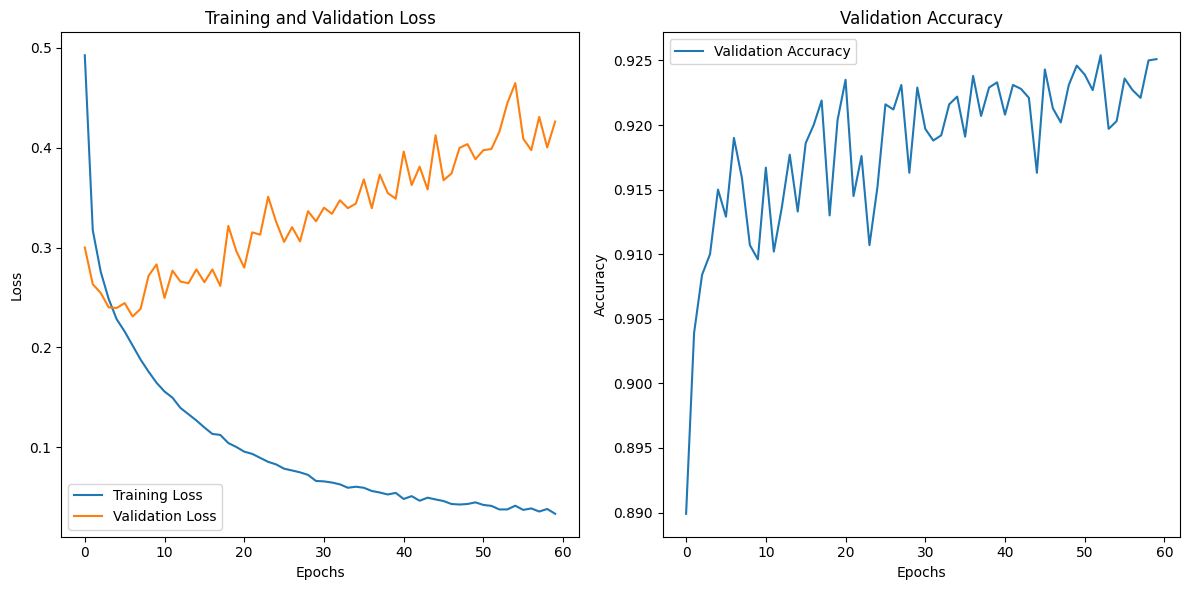

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_loss_epoch, label='Training Loss')
plt.plot(test_loss_epoch, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracy_epoch, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Вывод: по метрикам recall, precision, f1 можно увидеть, что данная модель с свертками справляется с заадчей лучше чем без них. Если быть точнее, то accuracy равен 0.92, что очень хорошо если сравнивать ее  с предыдущей . Проблема с переобучением осталось. Возможно нужно подобрать более лучший параметр для dropout.

# 3 Задание:

In [ ]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_set = torchvision.datasets.FashionMNIST("./data", download=True, train=True, transform=train_transforms)
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=test_transforms)

train_loader = DataLoader(train_set, batch_size=100)
test_loader = DataLoader(test_set, batch_size=100)

100%|██████████| 26421880/26421880 [00:02<00:00, 12469418.63it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 209500.48it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3878901.01it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6563002.13it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



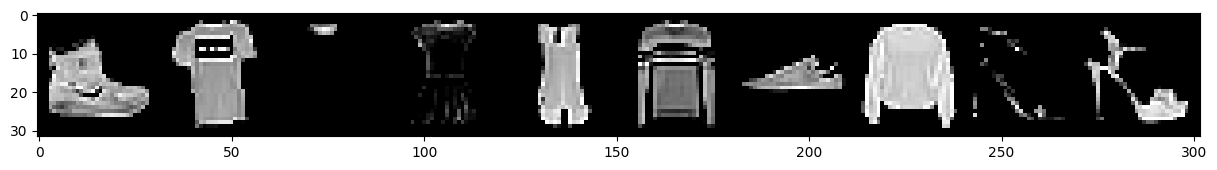

In [ ]:
demo_loader = torch.utils.data.DataLoader(train_set, batch_size=10)

batch = next(iter(demo_loader))
images, labels = batch
grid = torchvision.utils.make_grid(images, nrow=10)
plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))


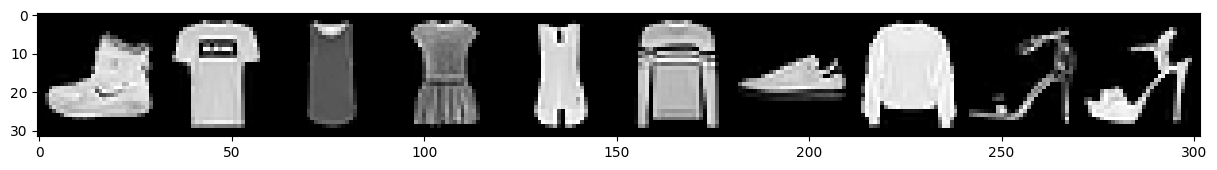

In [ ]:
demo_loader = torch.utils.data.DataLoader(train_set, batch_size=10)

batch = next(iter(demo_loader))
images, labels = batch
grid = torchvision.utils.make_grid(images, nrow=10)
plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))


### На этом можно увидеть что некоторые фотографии(объекты) были повернуты, отражены и нормализованы

In [ ]:
class MnistModel(nn.Module):
    def __init__(self):
        super(MnistModel, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.MaxPool2d(3)
        )
        self.linear1 = nn.Linear(64*4*4, 256)
        self.batch_norm1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout2d(0.5)
        self.linear2 = nn.Linear(256, 128)
        self.batch_norm2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout2d(0.5)
        self.linear3 = nn.Linear(128, 10)
        self.flat = nn.Flatten()

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.flat(x)
        x = F.leaky_relu(self.batch_norm1(self.linear1(x)))
        x = self.dropout1(x)
        x = F.leaky_relu(self.batch_norm2(self.linear2(x)))
        x = self.dropout2(x)
        x = self.linear3(x)
        return x
model = MnistModel()

In [ ]:
model.to('cuda')
summary(model,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             320
       BatchNorm2d-2           [-1, 32, 30, 30]              64
              ReLU-3           [-1, 32, 30, 30]               0
         MaxPool2d-4           [-1, 32, 15, 15]               0
            Conv2d-5           [-1, 64, 13, 13]          18,496
       BatchNorm2d-6           [-1, 64, 13, 13]             128
         LeakyReLU-7           [-1, 64, 13, 13]               0
         MaxPool2d-8             [-1, 64, 4, 4]               0
           Flatten-9                 [-1, 1024]               0
           Linear-10                  [-1, 256]         262,400
      BatchNorm1d-11                  [-1, 256]             512
        Dropout2d-12                  [-1, 256]               0
           Linear-13                  [-1, 128]          32,896
      BatchNorm1d-14                  [

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
BATCH_SIZE = 100
NUM_EPOCHS = 60

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE)

steps = 0
print_every = 200
train_loss_epoch = []
test_loss_epoch = []
accuracy_epoch = []
preds_hist = []
labels_hist = []

for e in range(NUM_EPOCHS):
    model.train()
    running_loss = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        preds = model(images.to(device))
        loss = loss_fn(preds, labels.to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_train_loss = running_loss / len(train_loader)
    train_loss_epoch.append(epoch_train_loss)

    model.eval()
    running_accuracy = 0
    running_test_loss = 0
    preds_list = []
    with torch.no_grad():
        for images, labels in test_loader:
            preds = model(images.to(device))
            test_loss = loss_fn(preds, labels.to(device))
            running_test_loss += test_loss.item()
            labels_hist.extend(np.squeeze(labels.numpy()))
            ps = torch.exp(preds)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape).to(device)
            preds_list.extend(top_class.cpu().numpy())
            running_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
    preds_hist.extend(np.squeeze(preds_list))
    epoch_test_loss = running_test_loss / len(test_loader)
    epoch_accuracy = running_accuracy / len(test_loader)

    test_loss_epoch.append(epoch_test_loss)
    accuracy_epoch.append(epoch_accuracy)

    print(f"Epoch: {e+1}/{NUM_EPOCHS}.. "
          f"Training Loss: {epoch_train_loss:.3f}.. "
          f"Test Loss: {epoch_test_loss:.3f}.. "
          f"Test Accuracy: {epoch_accuracy:.3f}")
    print(metrics.classification_report(preds_hist,labels_hist))

Epoch: 1/60.. Training Loss: 0.578.. Test Loss: 0.348.. Test Accuracy: 0.873
              precision    recall  f1-score   support

           0       0.85      0.78      0.81      1096
           1       0.97      0.99      0.98       988
           2       0.80      0.82      0.81       970
           3       0.91      0.86      0.88      1065
           4       0.82      0.80      0.81      1018
           5       0.92      0.99      0.95       935
           6       0.57      0.67      0.62       855
           7       0.95      0.91      0.93      1041
           8       0.97      0.97      0.97      1000
           9       0.96      0.93      0.95      1032

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.88      0.87      0.87     10000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 2/60.. Training Loss: 0.397.. Test Loss: 0.304.. Test Accuracy: 0.886
              precision    recall  f1-score   support

           0       0.86      0.79      0.82      2196
           1       0.97      0.99      0.98      1971
           2       0.83      0.82      0.82      2007
           3       0.90      0.87      0.89      2081
           4       0.82      0.81      0.82      2030
           5       0.95      0.96      0.96      1980
           6       0.59      0.69      0.64      1711
           7       0.93      0.93      0.93      1985
           8       0.97      0.98      0.97      1983
           9       0.96      0.94      0.95      2056

    accuracy                           0.88     20000
   macro avg       0.88      0.88      0.88     20000
weighted avg       0.88      0.88      0.88     20000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 3/60.. Training Loss: 0.354.. Test Loss: 0.283.. Test Accuracy: 0.896
              precision    recall  f1-score   support

           0       0.86      0.80      0.83      3202
           1       0.97      0.99      0.98      2953
           2       0.83      0.83      0.83      2994
           3       0.91      0.87      0.89      3140
           4       0.85      0.81      0.83      3134
           5       0.96      0.97      0.96      2975
           6       0.61      0.72      0.66      2564
           7       0.93      0.94      0.94      2969
           8       0.97      0.97      0.97      2984
           9       0.96      0.94      0.95      3085

    accuracy                           0.88     30000
   macro avg       0.88      0.88      0.88     30000
weighted avg       0.89      0.88      0.89     30000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 4/60.. Training Loss: 0.329.. Test Loss: 0.272.. Test Accuracy: 0.902
              precision    recall  f1-score   support

           0       0.86      0.81      0.84      4269
           1       0.98      0.99      0.98      3946
           2       0.83      0.84      0.84      3985
           3       0.91      0.87      0.89      4166
           4       0.86      0.81      0.83      4279
           5       0.96      0.97      0.96      3955
           6       0.61      0.74      0.67      3333
           7       0.94      0.94      0.94      3981
           8       0.97      0.97      0.97      3987
           9       0.97      0.94      0.95      4099

    accuracy                           0.89     40000
   macro avg       0.89      0.89      0.89     40000
weighted avg       0.89      0.89      0.89     40000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 5/60.. Training Loss: 0.313.. Test Loss: 0.263.. Test Accuracy: 0.904
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      5243
           1       0.98      0.99      0.98      4932
           2       0.83      0.85      0.84      4930
           3       0.91      0.88      0.89      5173
           4       0.87      0.81      0.84      5404
           5       0.96      0.97      0.96      4917
           6       0.63      0.74      0.68      4292
           7       0.94      0.94      0.94      5020
           8       0.97      0.97      0.97      4989
           9       0.96      0.95      0.96      5100

    accuracy                           0.89     50000
   macro avg       0.89      0.89      0.89     50000
weighted avg       0.90      0.89      0.89     50000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 6/60.. Training Loss: 0.304.. Test Loss: 0.258.. Test Accuracy: 0.907
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      6266
           1       0.98      0.99      0.98      5915
           2       0.84      0.85      0.84      5907
           3       0.92      0.88      0.90      6270
           4       0.87      0.81      0.84      6478
           5       0.96      0.97      0.97      5886
           6       0.64      0.75      0.69      5128
           7       0.95      0.94      0.94      6051
           8       0.97      0.98      0.97      5994
           9       0.96      0.95      0.96      6105

    accuracy                           0.89     60000
   macro avg       0.89      0.89      0.89     60000
weighted avg       0.90      0.89      0.90     60000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 7/60.. Training Loss: 0.290.. Test Loss: 0.251.. Test Accuracy: 0.909
              precision    recall  f1-score   support

           0       0.86      0.83      0.84      7289
           1       0.98      0.99      0.98      6907
           2       0.84      0.85      0.85      6919
           3       0.92      0.88      0.90      7325
           4       0.88      0.81      0.84      7542
           5       0.96      0.98      0.97      6862
           6       0.64      0.75      0.69      5989
           7       0.95      0.94      0.94      7068
           8       0.97      0.98      0.98      6985
           9       0.97      0.95      0.96      7114

    accuracy                           0.90     70000
   macro avg       0.90      0.90      0.90     70000
weighted avg       0.90      0.90      0.90     70000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 8/60.. Training Loss: 0.283.. Test Loss: 0.241.. Test Accuracy: 0.913
              precision    recall  f1-score   support

           0       0.86      0.83      0.85      8268
           1       0.98      0.99      0.98      7888
           2       0.85      0.85      0.85      7912
           3       0.92      0.88      0.90      8358
           4       0.88      0.82      0.85      8619
           5       0.96      0.98      0.97      7858
           6       0.65      0.76      0.70      6927
           7       0.95      0.94      0.95      8063
           8       0.98      0.98      0.98      7977
           9       0.97      0.95      0.96      8130

    accuracy                           0.90     80000
   macro avg       0.90      0.90      0.90     80000
weighted avg       0.90      0.90      0.90     80000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 9/60.. Training Loss: 0.275.. Test Loss: 0.245.. Test Accuracy: 0.911
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      9206
           1       0.98      0.99      0.98      8867
           2       0.85      0.86      0.85      8863
           3       0.92      0.88      0.90      9400
           4       0.88      0.82      0.85      9729
           5       0.96      0.98      0.97      8884
           6       0.66      0.76      0.71      7902
           7       0.95      0.94      0.95      9031
           8       0.98      0.98      0.98      8978
           9       0.97      0.95      0.96      9140

    accuracy                           0.90     90000
   macro avg       0.90      0.90      0.90     90000
weighted avg       0.90      0.90      0.90     90000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 10/60.. Training Loss: 0.270.. Test Loss: 0.232.. Test Accuracy: 0.914
              precision    recall  f1-score   support

           0       0.86      0.84      0.85     10225
           1       0.98      0.99      0.98      9846
           2       0.85      0.86      0.85      9850
           3       0.92      0.88      0.90     10423
           4       0.88      0.82      0.85     10753
           5       0.96      0.98      0.97      9886
           6       0.67      0.76      0.71      8860
           7       0.95      0.95      0.95     10039
           8       0.98      0.98      0.98      9984
           9       0.97      0.95      0.96     10134

    accuracy                           0.90    100000
   macro avg       0.90      0.90      0.90    100000
weighted avg       0.90      0.90      0.90    100000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 11/60.. Training Loss: 0.259.. Test Loss: 0.232.. Test Accuracy: 0.916
              precision    recall  f1-score   support

           0       0.86      0.84      0.85     11237
           1       0.98      0.99      0.98     10832
           2       0.85      0.86      0.86     10871
           3       0.92      0.88      0.90     11463
           4       0.88      0.82      0.85     11806
           5       0.96      0.98      0.97     10866
           6       0.67      0.76      0.72      9744
           7       0.95      0.95      0.95     11049
           8       0.98      0.98      0.98     10984
           9       0.97      0.95      0.96     11148

    accuracy                           0.90    110000
   macro avg       0.90      0.90      0.90    110000
weighted avg       0.91      0.90      0.90    110000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 12/60.. Training Loss: 0.256.. Test Loss: 0.233.. Test Accuracy: 0.916
              precision    recall  f1-score   support

           0       0.86      0.84      0.85     12284
           1       0.98      0.99      0.98     11826
           2       0.86      0.86      0.86     11936
           3       0.92      0.89      0.90     12473
           4       0.88      0.83      0.85     12809
           5       0.96      0.98      0.97     11844
           6       0.68      0.76      0.72     10622
           7       0.95      0.95      0.95     12076
           8       0.98      0.98      0.98     11982
           9       0.97      0.95      0.96     12148

    accuracy                           0.90    120000
   macro avg       0.90      0.90      0.90    120000
weighted avg       0.91      0.90      0.90    120000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 13/60.. Training Loss: 0.250.. Test Loss: 0.230.. Test Accuracy: 0.918
              precision    recall  f1-score   support

           0       0.86      0.84      0.85     13310
           1       0.98      0.99      0.99     12812
           2       0.86      0.86      0.86     12920
           3       0.92      0.89      0.91     13467
           4       0.88      0.83      0.85     13920
           5       0.97      0.98      0.97     12847
           6       0.68      0.77      0.72     11514
           7       0.95      0.95      0.95     13072
           8       0.98      0.98      0.98     12985
           9       0.97      0.96      0.96     13153

    accuracy                           0.90    130000
   macro avg       0.90      0.90      0.90    130000
weighted avg       0.91      0.90      0.91    130000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 14/60.. Training Loss: 0.249.. Test Loss: 0.232.. Test Accuracy: 0.916
              precision    recall  f1-score   support

           0       0.86      0.85      0.85     14316
           1       0.98      0.99      0.99     13793
           2       0.86      0.86      0.86     13900
           3       0.92      0.89      0.91     14539
           4       0.89      0.83      0.86     14985
           5       0.97      0.98      0.97     13820
           6       0.68      0.77      0.72     12412
           7       0.95      0.95      0.95     14059
           8       0.98      0.98      0.98     13978
           9       0.97      0.95      0.96     14198

    accuracy                           0.91    140000
   macro avg       0.91      0.91      0.90    140000
weighted avg       0.91      0.91      0.91    140000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 15/60.. Training Loss: 0.242.. Test Loss: 0.222.. Test Accuracy: 0.919
              precision    recall  f1-score   support

           0       0.87      0.85      0.86     15331
           1       0.98      0.99      0.99     14771
           2       0.86      0.87      0.86     14899
           3       0.92      0.89      0.91     15574
           4       0.89      0.83      0.86     16033
           5       0.97      0.98      0.97     14817
           6       0.69      0.77      0.73     13340
           7       0.95      0.95      0.95     15048
           8       0.98      0.98      0.98     14972
           9       0.97      0.95      0.96     15215

    accuracy                           0.91    150000
   macro avg       0.91      0.91      0.91    150000
weighted avg       0.91      0.91      0.91    150000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 16/60.. Training Loss: 0.240.. Test Loss: 0.221.. Test Accuracy: 0.918
              precision    recall  f1-score   support

           0       0.87      0.85      0.86     16345
           1       0.98      0.99      0.99     15755
           2       0.86      0.86      0.86     15950
           3       0.92      0.89      0.91     16595
           4       0.88      0.83      0.86     17022
           5       0.97      0.98      0.97     15805
           6       0.69      0.77      0.73     14283
           7       0.95      0.95      0.95     16057
           8       0.98      0.98      0.98     15968
           9       0.97      0.95      0.96     16220

    accuracy                           0.91    160000
   macro avg       0.91      0.91      0.91    160000
weighted avg       0.91      0.91      0.91    160000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 17/60.. Training Loss: 0.236.. Test Loss: 0.223.. Test Accuracy: 0.918
              precision    recall  f1-score   support

           0       0.87      0.85      0.86     17316
           1       0.98      0.99      0.99     16730
           2       0.86      0.87      0.86     16910
           3       0.93      0.89      0.91     17667
           4       0.89      0.83      0.86     18063
           5       0.97      0.98      0.97     16812
           6       0.69      0.77      0.73     15261
           7       0.95      0.95      0.95     17043
           8       0.98      0.98      0.98     16966
           9       0.97      0.96      0.96     17232

    accuracy                           0.91    170000
   macro avg       0.91      0.91      0.91    170000
weighted avg       0.91      0.91      0.91    170000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 18/60.. Training Loss: 0.233.. Test Loss: 0.221.. Test Accuracy: 0.919
              precision    recall  f1-score   support

           0       0.87      0.85      0.86     18332
           1       0.98      0.99      0.99     17711
           2       0.86      0.87      0.87     17937
           3       0.93      0.89      0.91     18723
           4       0.89      0.83      0.86     19084
           5       0.97      0.98      0.97     17796
           6       0.70      0.77      0.73     16156
           7       0.95      0.95      0.95     18069
           8       0.98      0.98      0.98     17968
           9       0.97      0.96      0.96     18224

    accuracy                           0.91    180000
   macro avg       0.91      0.91      0.91    180000
weighted avg       0.91      0.91      0.91    180000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 19/60.. Training Loss: 0.229.. Test Loss: 0.215.. Test Accuracy: 0.922
              precision    recall  f1-score   support

           0       0.87      0.85      0.86     19369
           1       0.98      0.99      0.99     18701
           2       0.87      0.87      0.87     18954
           3       0.93      0.89      0.91     19728
           4       0.89      0.84      0.86     20153
           5       0.97      0.98      0.97     18792
           6       0.70      0.78      0.73     17039
           7       0.95      0.95      0.95     19055
           8       0.98      0.98      0.98     18963
           9       0.97      0.96      0.96     19246

    accuracy                           0.91    190000
   macro avg       0.91      0.91      0.91    190000
weighted avg       0.91      0.91      0.91    190000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 20/60.. Training Loss: 0.226.. Test Loss: 0.213.. Test Accuracy: 0.924
              precision    recall  f1-score   support

           0       0.87      0.85      0.86     20349
           1       0.98      0.99      0.99     19687
           2       0.87      0.87      0.87     19931
           3       0.93      0.89      0.91     20758
           4       0.89      0.84      0.86     21182
           5       0.97      0.98      0.97     19811
           6       0.70      0.78      0.74     18029
           7       0.95      0.95      0.95     20044
           8       0.98      0.98      0.98     19963
           9       0.97      0.96      0.96     20246

    accuracy                           0.91    200000
   macro avg       0.91      0.91      0.91    200000
weighted avg       0.91      0.91      0.91    200000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 21/60.. Training Loss: 0.223.. Test Loss: 0.210.. Test Accuracy: 0.924
              precision    recall  f1-score   support

           0       0.87      0.85      0.86     21364
           1       0.98      0.99      0.99     20677
           2       0.87      0.87      0.87     20909
           3       0.93      0.89      0.91     21794
           4       0.89      0.84      0.86     22194
           5       0.97      0.98      0.98     20806
           6       0.70      0.78      0.74     18997
           7       0.95      0.95      0.95     21045
           8       0.98      0.98      0.98     20957
           9       0.97      0.96      0.96     21257

    accuracy                           0.91    210000
   macro avg       0.91      0.91      0.91    210000
weighted avg       0.91      0.91      0.91    210000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 22/60.. Training Loss: 0.220.. Test Loss: 0.214.. Test Accuracy: 0.922
              precision    recall  f1-score   support

           0       0.87      0.85      0.86     22353
           1       0.98      0.99      0.99     21665
           2       0.87      0.87      0.87     21939
           3       0.93      0.89      0.91     22823
           4       0.89      0.84      0.86     23184
           5       0.97      0.98      0.98     21793
           6       0.71      0.78      0.74     19970
           7       0.95      0.95      0.95     22026
           8       0.98      0.98      0.98     21955
           9       0.97      0.96      0.96     22292

    accuracy                           0.91    220000
   macro avg       0.91      0.91      0.91    220000
weighted avg       0.91      0.91      0.91    220000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 23/60.. Training Loss: 0.217.. Test Loss: 0.209.. Test Accuracy: 0.924
              precision    recall  f1-score   support

           0       0.87      0.86      0.86     23346
           1       0.98      0.99      0.99     22651
           2       0.87      0.87      0.87     22932
           3       0.93      0.90      0.91     23858
           4       0.89      0.84      0.86     24209
           5       0.97      0.98      0.98     22777
           6       0.71      0.78      0.74     20932
           7       0.95      0.95      0.95     23031
           8       0.98      0.98      0.98     22958
           9       0.97      0.96      0.96     23306

    accuracy                           0.91    230000
   macro avg       0.91      0.91      0.91    230000
weighted avg       0.91      0.91      0.91    230000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 24/60.. Training Loss: 0.216.. Test Loss: 0.213.. Test Accuracy: 0.922
              precision    recall  f1-score   support

           0       0.87      0.86      0.86     24357
           1       0.98      0.99      0.99     23640
           2       0.87      0.87      0.87     23932
           3       0.93      0.90      0.91     24841
           4       0.89      0.84      0.86     25225
           5       0.97      0.98      0.98     23771
           6       0.71      0.78      0.74     21924
           7       0.96      0.95      0.95     24041
           8       0.98      0.98      0.98     23960
           9       0.97      0.96      0.96     24309

    accuracy                           0.91    240000
   macro avg       0.91      0.91      0.91    240000
weighted avg       0.91      0.91      0.91    240000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 25/60.. Training Loss: 0.211.. Test Loss: 0.219.. Test Accuracy: 0.920
              precision    recall  f1-score   support

           0       0.87      0.86      0.86     25389
           1       0.98      0.99      0.99     24631
           2       0.87      0.87      0.87     25003
           3       0.93      0.90      0.91     25833
           4       0.89      0.85      0.87     26203
           5       0.97      0.98      0.98     24763
           6       0.71      0.78      0.75     22858
           7       0.96      0.95      0.95     25047
           8       0.98      0.98      0.98     24959
           9       0.97      0.96      0.96     25314

    accuracy                           0.91    250000
   macro avg       0.91      0.91      0.91    250000
weighted avg       0.91      0.91      0.91    250000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 26/60.. Training Loss: 0.210.. Test Loss: 0.210.. Test Accuracy: 0.926
              precision    recall  f1-score   support

           0       0.87      0.86      0.86     26375
           1       0.98      0.99      0.99     25615
           2       0.87      0.87      0.87     25988
           3       0.93      0.90      0.91     26864
           4       0.89      0.85      0.87     27224
           5       0.97      0.98      0.98     25769
           6       0.72      0.78      0.75     23853
           7       0.96      0.95      0.96     26029
           8       0.98      0.98      0.98     25955
           9       0.97      0.96      0.96     26328

    accuracy                           0.91    260000
   macro avg       0.91      0.91      0.91    260000
weighted avg       0.91      0.91      0.91    260000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 27/60.. Training Loss: 0.206.. Test Loss: 0.215.. Test Accuracy: 0.923
              precision    recall  f1-score   support

           0       0.87      0.86      0.86     27355
           1       0.98      0.99      0.99     26604
           2       0.87      0.87      0.87     27040
           3       0.93      0.90      0.91     27860
           4       0.89      0.85      0.87     28193
           5       0.97      0.98      0.98     26772
           6       0.72      0.78      0.75     24856
           7       0.96      0.96      0.96     27017
           8       0.98      0.98      0.98     26964
           9       0.97      0.96      0.96     27339

    accuracy                           0.91    270000
   macro avg       0.91      0.91      0.91    270000
weighted avg       0.91      0.91      0.91    270000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 28/60.. Training Loss: 0.207.. Test Loss: 0.209.. Test Accuracy: 0.923
              precision    recall  f1-score   support

           0       0.87      0.86      0.86     28339
           1       0.98      0.99      0.99     27599
           2       0.87      0.87      0.87     28025
           3       0.93      0.90      0.91     28879
           4       0.89      0.85      0.87     29192
           5       0.97      0.98      0.98     27761
           6       0.72      0.78      0.75     25864
           7       0.96      0.96      0.96     28023
           8       0.98      0.98      0.98     27970
           9       0.97      0.96      0.96     28348

    accuracy                           0.91    280000
   macro avg       0.91      0.91      0.91    280000
weighted avg       0.91      0.91      0.91    280000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 29/60.. Training Loss: 0.206.. Test Loss: 0.208.. Test Accuracy: 0.926
              precision    recall  f1-score   support

           0       0.87      0.86      0.86     29392
           1       0.98      0.99      0.99     28593
           2       0.87      0.87      0.87     29060
           3       0.93      0.90      0.91     29873
           4       0.88      0.85      0.87     30188
           5       0.97      0.98      0.98     28758
           6       0.72      0.78      0.75     26792
           7       0.96      0.96      0.96     29019
           8       0.98      0.98      0.98     28968
           9       0.97      0.96      0.96     29357

    accuracy                           0.91    290000
   macro avg       0.91      0.91      0.91    290000
weighted avg       0.92      0.91      0.91    290000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 30/60.. Training Loss: 0.206.. Test Loss: 0.209.. Test Accuracy: 0.924
              precision    recall  f1-score   support

           0       0.87      0.86      0.86     30399
           1       0.98      0.99      0.99     29584
           2       0.88      0.87      0.87     30141
           3       0.93      0.90      0.92     30889
           4       0.88      0.85      0.87     31140
           5       0.97      0.98      0.98     29764
           6       0.72      0.78      0.75     27742
           7       0.96      0.96      0.96     29989
           8       0.98      0.98      0.98     29968
           9       0.97      0.96      0.96     30384

    accuracy                           0.91    300000
   macro avg       0.91      0.91      0.91    300000
weighted avg       0.92      0.91      0.91    300000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 31/60.. Training Loss: 0.202.. Test Loss: 0.208.. Test Accuracy: 0.924
              precision    recall  f1-score   support

           0       0.87      0.86      0.86     31424
           1       0.98      0.99      0.99     30574
           2       0.88      0.87      0.87     31213
           3       0.93      0.90      0.92     31906
           4       0.88      0.85      0.87     32104
           5       0.97      0.98      0.98     30773
           6       0.72      0.78      0.75     28678
           7       0.96      0.96      0.96     30981
           8       0.98      0.98      0.98     30960
           9       0.97      0.96      0.96     31387

    accuracy                           0.91    310000
   macro avg       0.91      0.91      0.91    310000
weighted avg       0.92      0.91      0.92    310000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 32/60.. Training Loss: 0.199.. Test Loss: 0.206.. Test Accuracy: 0.927
              precision    recall  f1-score   support

           0       0.87      0.86      0.86     32448
           1       0.98      0.99      0.99     31563
           2       0.88      0.87      0.87     32235
           3       0.93      0.90      0.92     32910
           4       0.88      0.85      0.87     33063
           5       0.97      0.98      0.98     31779
           6       0.73      0.78      0.75     29680
           7       0.96      0.96      0.96     31996
           8       0.98      0.98      0.98     31957
           9       0.97      0.96      0.96     32369

    accuracy                           0.92    320000
   macro avg       0.92      0.91      0.91    320000
weighted avg       0.92      0.92      0.92    320000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 33/60.. Training Loss: 0.196.. Test Loss: 0.203.. Test Accuracy: 0.926
              precision    recall  f1-score   support

           0       0.87      0.86      0.86     33439
           1       0.98      0.99      0.99     32552
           2       0.88      0.87      0.88     33241
           3       0.93      0.90      0.92     33916
           4       0.88      0.85      0.87     34071
           5       0.97      0.98      0.98     32773
           6       0.73      0.78      0.75     30678
           7       0.96      0.96      0.96     33001
           8       0.98      0.98      0.98     32957
           9       0.97      0.96      0.96     33372

    accuracy                           0.92    330000
   macro avg       0.92      0.92      0.92    330000
weighted avg       0.92      0.92      0.92    330000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 34/60.. Training Loss: 0.198.. Test Loss: 0.208.. Test Accuracy: 0.923
              precision    recall  f1-score   support

           0       0.87      0.86      0.86     34455
           1       0.98      0.99      0.99     33537
           2       0.88      0.87      0.88     34277
           3       0.93      0.90      0.92     34951
           4       0.88      0.86      0.87     35042
           5       0.97      0.98      0.98     33766
           6       0.73      0.78      0.75     31638
           7       0.96      0.96      0.96     34009
           8       0.98      0.98      0.98     33947
           9       0.97      0.96      0.96     34378

    accuracy                           0.92    340000
   macro avg       0.92      0.92      0.92    340000
weighted avg       0.92      0.92      0.92    340000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 35/60.. Training Loss: 0.194.. Test Loss: 0.212.. Test Accuracy: 0.923
              precision    recall  f1-score   support

           0       0.87      0.86      0.87     35434
           1       0.98      0.99      0.99     34527
           2       0.88      0.87      0.88     35305
           3       0.93      0.91      0.92     35967
           4       0.88      0.86      0.87     36042
           5       0.98      0.98      0.98     34782
           6       0.73      0.78      0.76     32622
           7       0.96      0.96      0.96     34982
           8       0.98      0.98      0.98     34944
           9       0.97      0.96      0.97     35395

    accuracy                           0.92    350000
   macro avg       0.92      0.92      0.92    350000
weighted avg       0.92      0.92      0.92    350000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 36/60.. Training Loss: 0.190.. Test Loss: 0.203.. Test Accuracy: 0.929
              precision    recall  f1-score   support

           0       0.87      0.86      0.87     36462
           1       0.98      0.99      0.99     35518
           2       0.88      0.87      0.88     36340
           3       0.93      0.91      0.92     36984
           4       0.88      0.86      0.87     36995
           5       0.98      0.98      0.98     35786
           6       0.73      0.78      0.76     33598
           7       0.96      0.96      0.96     35998
           8       0.98      0.99      0.98     35941
           9       0.97      0.96      0.97     36378

    accuracy                           0.92    360000
   macro avg       0.92      0.92      0.92    360000
weighted avg       0.92      0.92      0.92    360000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 37/60.. Training Loss: 0.192.. Test Loss: 0.206.. Test Accuracy: 0.926
              precision    recall  f1-score   support

           0       0.87      0.86      0.87     37434
           1       0.98      0.99      0.99     36511
           2       0.88      0.87      0.88     37348
           3       0.93      0.91      0.92     38027
           4       0.88      0.86      0.87     37963
           5       0.98      0.98      0.98     36783
           6       0.73      0.78      0.76     34611
           7       0.96      0.96      0.96     36953
           8       0.98      0.99      0.98     36940
           9       0.97      0.96      0.97     37430

    accuracy                           0.92    370000
   macro avg       0.92      0.92      0.92    370000
weighted avg       0.92      0.92      0.92    370000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 38/60.. Training Loss: 0.189.. Test Loss: 0.212.. Test Accuracy: 0.924
              precision    recall  f1-score   support

           0       0.87      0.86      0.87     38438
           1       0.98      0.99      0.99     37497
           2       0.88      0.87      0.88     38408
           3       0.93      0.91      0.92     39066
           4       0.88      0.86      0.87     38914
           5       0.98      0.98      0.98     37799
           6       0.73      0.78      0.76     35569
           7       0.96      0.96      0.96     37925
           8       0.98      0.99      0.98     37937
           9       0.97      0.96      0.97     38447

    accuracy                           0.92    380000
   macro avg       0.92      0.92      0.92    380000
weighted avg       0.92      0.92      0.92    380000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 39/60.. Training Loss: 0.186.. Test Loss: 0.216.. Test Accuracy: 0.926
              precision    recall  f1-score   support

           0       0.87      0.86      0.87     39501
           1       0.98      0.99      0.99     38484
           2       0.88      0.87      0.88     39467
           3       0.93      0.91      0.92     40085
           4       0.88      0.86      0.87     39873
           5       0.98      0.98      0.98     38813
           6       0.73      0.78      0.76     36482
           7       0.96      0.96      0.96     38876
           8       0.98      0.99      0.98     38934
           9       0.97      0.96      0.97     39485

    accuracy                           0.92    390000
   macro avg       0.92      0.92      0.92    390000
weighted avg       0.92      0.92      0.92    390000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 40/60.. Training Loss: 0.189.. Test Loss: 0.205.. Test Accuracy: 0.927
              precision    recall  f1-score   support

           0       0.87      0.86      0.87     40530
           1       0.98      0.99      0.99     39469
           2       0.88      0.87      0.88     40488
           3       0.93      0.91      0.92     41139
           4       0.88      0.86      0.87     40807
           5       0.98      0.98      0.98     39814
           6       0.74      0.79      0.76     37463
           7       0.96      0.96      0.96     39882
           8       0.98      0.99      0.98     39927
           9       0.97      0.96      0.97     40481

    accuracy                           0.92    400000
   macro avg       0.92      0.92      0.92    400000
weighted avg       0.92      0.92      0.92    400000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 41/60.. Training Loss: 0.185.. Test Loss: 0.203.. Test Accuracy: 0.927
              precision    recall  f1-score   support

           0       0.87      0.86      0.87     41514
           1       0.98      0.99      0.99     40457
           2       0.88      0.87      0.88     41506
           3       0.93      0.91      0.92     42161
           4       0.88      0.86      0.87     41784
           5       0.98      0.98      0.98     40815
           6       0.74      0.79      0.76     38472
           7       0.96      0.96      0.96     40859
           8       0.98      0.99      0.98     40926
           9       0.97      0.96      0.97     41506

    accuracy                           0.92    410000
   macro avg       0.92      0.92      0.92    410000
weighted avg       0.92      0.92      0.92    410000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 42/60.. Training Loss: 0.186.. Test Loss: 0.202.. Test Accuracy: 0.929
              precision    recall  f1-score   support

           0       0.87      0.86      0.87     42528
           1       0.98      0.99      0.99     41452
           2       0.88      0.87      0.88     42503
           3       0.93      0.91      0.92     43177
           4       0.88      0.86      0.87     42822
           5       0.98      0.98      0.98     41822
           6       0.74      0.79      0.76     39411
           7       0.96      0.96      0.96     41869
           8       0.98      0.99      0.98     41923
           9       0.97      0.96      0.97     42493

    accuracy                           0.92    420000
   macro avg       0.92      0.92      0.92    420000
weighted avg       0.92      0.92      0.92    420000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 43/60.. Training Loss: 0.183.. Test Loss: 0.204.. Test Accuracy: 0.927
              precision    recall  f1-score   support

           0       0.87      0.86      0.87     43538
           1       0.98      0.99      0.99     42449
           2       0.88      0.87      0.88     43522
           3       0.93      0.91      0.92     44206
           4       0.88      0.86      0.87     43801
           5       0.98      0.98      0.98     42839
           6       0.74      0.79      0.76     40370
           7       0.96      0.96      0.96     42840
           8       0.98      0.99      0.98     42925
           9       0.97      0.96      0.97     43510

    accuracy                           0.92    430000
   macro avg       0.92      0.92      0.92    430000
weighted avg       0.92      0.92      0.92    430000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 44/60.. Training Loss: 0.180.. Test Loss: 0.219.. Test Accuracy: 0.925
              precision    recall  f1-score   support

           0       0.87      0.86      0.87     44571
           1       0.98      0.99      0.99     43446
           2       0.88      0.87      0.88     44599
           3       0.93      0.91      0.92     45195
           4       0.88      0.86      0.87     44738
           5       0.98      0.98      0.98     43831
           6       0.74      0.79      0.76     41339
           7       0.96      0.96      0.96     43830
           8       0.98      0.99      0.99     43920
           9       0.97      0.96      0.97     44531

    accuracy                           0.92    440000
   macro avg       0.92      0.92      0.92    440000
weighted avg       0.92      0.92      0.92    440000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 45/60.. Training Loss: 0.178.. Test Loss: 0.206.. Test Accuracy: 0.927
              precision    recall  f1-score   support

           0       0.87      0.86      0.87     45564
           1       0.98      0.99      0.99     44436
           2       0.89      0.87      0.88     45599
           3       0.93      0.91      0.92     46219
           4       0.88      0.87      0.87     45699
           5       0.98      0.98      0.98     44834
           6       0.74      0.79      0.76     42373
           7       0.96      0.96      0.96     44821
           8       0.98      0.99      0.99     44915
           9       0.97      0.96      0.97     45540

    accuracy                           0.92    450000
   macro avg       0.92      0.92      0.92    450000
weighted avg       0.92      0.92      0.92    450000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 46/60.. Training Loss: 0.177.. Test Loss: 0.211.. Test Accuracy: 0.926
              precision    recall  f1-score   support

           0       0.87      0.86      0.87     46612
           1       0.98      0.99      0.99     45426
           2       0.89      0.87      0.88     46662
           3       0.93      0.91      0.92     47227
           4       0.88      0.87      0.87     46643
           5       0.98      0.98      0.98     45821
           6       0.74      0.79      0.76     43318
           7       0.96      0.96      0.96     45850
           8       0.98      0.99      0.99     45915
           9       0.97      0.96      0.97     46526

    accuracy                           0.92    460000
   macro avg       0.92      0.92      0.92    460000
weighted avg       0.92      0.92      0.92    460000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 47/60.. Training Loss: 0.180.. Test Loss: 0.206.. Test Accuracy: 0.928
              precision    recall  f1-score   support

           0       0.87      0.86      0.87     47624
           1       0.98      1.00      0.99     46416
           2       0.89      0.87      0.88     47697
           3       0.93      0.91      0.92     48215
           4       0.88      0.87      0.87     47635
           5       0.98      0.98      0.98     46827
           6       0.74      0.79      0.76     44303
           7       0.96      0.96      0.96     46859
           8       0.98      0.99      0.99     46910
           9       0.97      0.96      0.97     47514

    accuracy                           0.92    470000
   macro avg       0.92      0.92      0.92    470000
weighted avg       0.92      0.92      0.92    470000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 48/60.. Training Loss: 0.177.. Test Loss: 0.203.. Test Accuracy: 0.927
              precision    recall  f1-score   support

           0       0.87      0.86      0.87     48668
           1       0.98      1.00      0.99     47406
           2       0.89      0.87      0.88     48710
           3       0.93      0.91      0.92     49240
           4       0.88      0.87      0.87     48604
           5       0.98      0.98      0.98     47840
           6       0.74      0.79      0.76     45264
           7       0.96      0.96      0.96     47845
           8       0.98      0.99      0.99     47904
           9       0.97      0.96      0.97     48519

    accuracy                           0.92    480000
   macro avg       0.92      0.92      0.92    480000
weighted avg       0.92      0.92      0.92    480000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 49/60.. Training Loss: 0.175.. Test Loss: 0.203.. Test Accuracy: 0.930
              precision    recall  f1-score   support

           0       0.87      0.86      0.87     49677
           1       0.98      1.00      0.99     48398
           2       0.89      0.87      0.88     49682
           3       0.93      0.91      0.92     50259
           4       0.88      0.87      0.87     49632
           5       0.98      0.98      0.98     48838
           6       0.74      0.79      0.76     46239
           7       0.96      0.96      0.96     48857
           8       0.98      0.99      0.99     48906
           9       0.97      0.96      0.97     49512

    accuracy                           0.92    490000
   macro avg       0.92      0.92      0.92    490000
weighted avg       0.92      0.92      0.92    490000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 50/60.. Training Loss: 0.174.. Test Loss: 0.200.. Test Accuracy: 0.930
              precision    recall  f1-score   support

           0       0.88      0.86      0.87     50695
           1       0.98      1.00      0.99     49391
           2       0.89      0.87      0.88     50686
           3       0.93      0.91      0.92     51284
           4       0.88      0.87      0.87     50624
           5       0.98      0.98      0.98     49841
           6       0.74      0.79      0.77     47208
           7       0.96      0.96      0.96     49843
           8       0.98      0.99      0.99     49902
           9       0.97      0.96      0.97     50526

    accuracy                           0.92    500000
   macro avg       0.92      0.92      0.92    500000
weighted avg       0.92      0.92      0.92    500000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 51/60.. Training Loss: 0.173.. Test Loss: 0.200.. Test Accuracy: 0.930
              precision    recall  f1-score   support

           0       0.88      0.86      0.87     51725
           1       0.98      1.00      0.99     50385
           2       0.89      0.87      0.88     51722
           3       0.93      0.91      0.92     52297
           4       0.88      0.87      0.87     51593
           5       0.98      0.98      0.98     50841
           6       0.74      0.79      0.77     48163
           7       0.96      0.96      0.96     50822
           8       0.98      0.99      0.99     50901
           9       0.97      0.96      0.97     51551

    accuracy                           0.92    510000
   macro avg       0.92      0.92      0.92    510000
weighted avg       0.92      0.92      0.92    510000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 52/60.. Training Loss: 0.172.. Test Loss: 0.203.. Test Accuracy: 0.931
              precision    recall  f1-score   support

           0       0.88      0.86      0.87     52759
           1       0.98      1.00      0.99     51374
           2       0.89      0.88      0.88     52720
           3       0.93      0.91      0.92     53312
           4       0.88      0.87      0.87     52603
           5       0.98      0.98      0.98     51847
           6       0.74      0.79      0.77     49110
           7       0.96      0.96      0.96     51808
           8       0.98      0.99      0.99     51904
           9       0.97      0.96      0.97     52563

    accuracy                           0.92    520000
   macro avg       0.92      0.92      0.92    520000
weighted avg       0.92      0.92      0.92    520000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 53/60.. Training Loss: 0.172.. Test Loss: 0.207.. Test Accuracy: 0.927
              precision    recall  f1-score   support

           0       0.88      0.86      0.87     53761
           1       0.98      1.00      0.99     52365
           2       0.89      0.87      0.88     53790
           3       0.93      0.91      0.92     54330
           4       0.88      0.87      0.87     53543
           5       0.98      0.98      0.98     52853
           6       0.75      0.79      0.77     50083
           7       0.96      0.96      0.96     52804
           8       0.98      0.99      0.99     52906
           9       0.97      0.96      0.97     53565

    accuracy                           0.92    530000
   macro avg       0.92      0.92      0.92    530000
weighted avg       0.92      0.92      0.92    530000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 54/60.. Training Loss: 0.168.. Test Loss: 0.201.. Test Accuracy: 0.929
              precision    recall  f1-score   support

           0       0.88      0.86      0.87     54789
           1       0.98      1.00      0.99     53357
           2       0.89      0.87      0.88     54836
           3       0.93      0.91      0.92     55336
           4       0.88      0.87      0.87     54514
           5       0.98      0.98      0.98     53852
           6       0.75      0.79      0.77     51031
           7       0.96      0.96      0.96     53814
           8       0.98      0.99      0.99     53911
           9       0.97      0.96      0.97     54560

    accuracy                           0.92    540000
   macro avg       0.92      0.92      0.92    540000
weighted avg       0.92      0.92      0.92    540000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 55/60.. Training Loss: 0.168.. Test Loss: 0.205.. Test Accuracy: 0.932
              precision    recall  f1-score   support

           0       0.88      0.86      0.87     55782
           1       0.98      1.00      0.99     54348
           2       0.89      0.88      0.88     55797
           3       0.93      0.91      0.92     56352
           4       0.88      0.87      0.87     55582
           5       0.98      0.98      0.98     54858
           6       0.75      0.79      0.77     52007
           7       0.96      0.96      0.96     54801
           8       0.98      0.99      0.99     54902
           9       0.97      0.96      0.97     55571

    accuracy                           0.92    550000
   macro avg       0.92      0.92      0.92    550000
weighted avg       0.92      0.92      0.92    550000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 56/60.. Training Loss: 0.168.. Test Loss: 0.202.. Test Accuracy: 0.931
              precision    recall  f1-score   support

           0       0.88      0.86      0.87     56805
           1       0.98      1.00      0.99     55341
           2       0.89      0.88      0.88     56824
           3       0.93      0.91      0.92     57343
           4       0.88      0.87      0.88     56589
           5       0.98      0.98      0.98     55860
           6       0.75      0.79      0.77     52969
           7       0.96      0.96      0.96     55801
           8       0.98      0.99      0.99     55895
           9       0.97      0.96      0.97     56573

    accuracy                           0.92    560000
   macro avg       0.92      0.92      0.92    560000
weighted avg       0.92      0.92      0.92    560000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 57/60.. Training Loss: 0.169.. Test Loss: 0.196.. Test Accuracy: 0.932
              precision    recall  f1-score   support

           0       0.88      0.86      0.87     57825
           1       0.98      1.00      0.99     56335
           2       0.89      0.88      0.88     57835
           3       0.93      0.91      0.92     58363
           4       0.88      0.87      0.88     57589
           5       0.98      0.98      0.98     56851
           6       0.75      0.79      0.77     53925
           7       0.96      0.96      0.96     56813
           8       0.98      0.99      0.99     56891
           9       0.97      0.96      0.97     57573

    accuracy                           0.92    570000
   macro avg       0.92      0.92      0.92    570000
weighted avg       0.92      0.92      0.92    570000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 58/60.. Training Loss: 0.165.. Test Loss: 0.203.. Test Accuracy: 0.932
              precision    recall  f1-score   support

           0       0.88      0.86      0.87     58865
           1       0.98      1.00      0.99     57328
           2       0.89      0.88      0.88     58870
           3       0.93      0.91      0.92     59363
           4       0.88      0.87      0.88     58579
           5       0.98      0.98      0.98     57858
           6       0.75      0.79      0.77     54866
           7       0.96      0.96      0.96     57809
           8       0.98      0.99      0.99     57888
           9       0.97      0.96      0.97     58574

    accuracy                           0.92    580000
   macro avg       0.92      0.92      0.92    580000
weighted avg       0.92      0.92      0.92    580000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 59/60.. Training Loss: 0.166.. Test Loss: 0.199.. Test Accuracy: 0.933
              precision    recall  f1-score   support

           0       0.88      0.86      0.87     59879
           1       0.98      1.00      0.99     58319
           2       0.89      0.88      0.88     59904
           3       0.93      0.91      0.92     60387
           4       0.88      0.87      0.88     59548
           5       0.98      0.98      0.98     58866
           6       0.75      0.79      0.77     55828
           7       0.96      0.96      0.96     58796
           8       0.99      0.99      0.99     58891
           9       0.97      0.96      0.97     59582

    accuracy                           0.92    590000
   macro avg       0.92      0.92      0.92    590000
weighted avg       0.92      0.92      0.92    590000



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 60/60.. Training Loss: 0.166.. Test Loss: 0.200.. Test Accuracy: 0.933
              precision    recall  f1-score   support

           0       0.88      0.86      0.87     60906
           1       0.98      1.00      0.99     59307
           2       0.89      0.88      0.88     60887
           3       0.93      0.91      0.92     61408
           4       0.88      0.87      0.88     60557
           5       0.98      0.98      0.98     59874
           6       0.75      0.79      0.77     56794
           7       0.96      0.96      0.96     59777
           8       0.99      0.99      0.99     59892
           9       0.97      0.96      0.97     60598

    accuracy                           0.92    600000
   macro avg       0.92      0.92      0.92    600000
weighted avg       0.92      0.92      0.92    600000



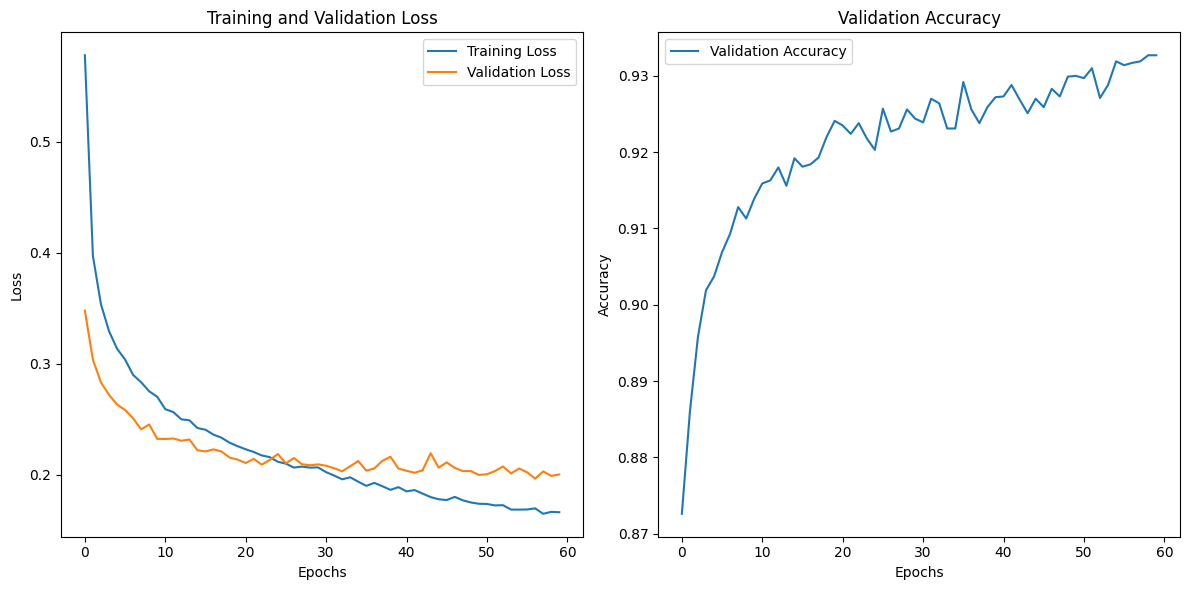

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_loss_epoch, label='Training Loss')
plt.plot(test_loss_epoch, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracy_epoch, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Выводы: аугментации положительно влияют на модель, так как они увеличивают выборку с помощью модификации. На графике видно, что проблема переобучения была немного решена и метрики стали лучше. Например, акураси 0.93 и loss 0.2, что довольно хорошо, если сравнивать с моделью с предыдущего задания. Я сделал и проверил аугментацию, проверив картинки. Затем это увеличило выборку и сделало модель лучше. В целом, понял что аугментация полезный способ улучшить чтобы раздуть выборку и улучшить метрики модели

# Задание 4:

## 1-модель)

In [ ]:
class MnistModel(nn.Module):
    def __init__(self):
        super(MnistModel, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.linear1 = nn.Linear(1152, 256)
        self.batch_norm1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.5)
        self.linear2 = nn.Linear(256, 128)
        self.batch_norm2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.5)
        self.linear3 = nn.Linear(128, 10)
        self.flat = nn.Flatten()

    def forward(self, x):
        x = self.layer1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        identity = x
        x = F.relu(self.bn3(self.conv3(x)))
        x = x + identity
        x = self.pool(x)
        x = F.relu(self.bn4(self.conv4(x)))
        identity = x
        x = F.relu(self.bn5(self.conv5(x)))
        x = x + identity
        x = self.pool(x)
        x = self.flat(x)
        x = F.leaky_relu(self.batch_norm1(self.linear1(x)))
        x = self.dropout1(x)
        x = F.leaky_relu(self.batch_norm2(self.linear2(x)))
        x = self.dropout2(x)
        x = self.linear3(x)
        return x

model = MnistModel()

In [ ]:
model.to('cuda')
summary(model,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             320
       BatchNorm2d-2           [-1, 32, 30, 30]              64
              ReLU-3           [-1, 32, 30, 30]               0
         MaxPool2d-4           [-1, 32, 15, 15]               0
            Conv2d-5           [-1, 64, 15, 15]          18,496
       BatchNorm2d-6           [-1, 64, 15, 15]             128
            Conv2d-7           [-1, 64, 15, 15]          36,928
       BatchNorm2d-8           [-1, 64, 15, 15]             128
         MaxPool2d-9             [-1, 64, 7, 7]               0
           Conv2d-10            [-1, 128, 7, 7]          73,856
      BatchNorm2d-11            [-1, 128, 7, 7]             256
           Conv2d-12            [-1, 128, 7, 7]         147,584
      BatchNorm2d-13            [-1, 128, 7, 7]             256
        MaxPool2d-14            [-1, 12

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
BATCH_SIZE = 100
NUM_EPOCHS = 60

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE)

steps = 0
print_every = 200
train_loss_epoch = []
test_loss_epoch = []
accuracy_epoch = []
preds_hist = []
labels_hist = []

for e in range(NUM_EPOCHS):
    model.train()
    running_loss = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        preds = model(images.to(device))
        loss = loss_fn(preds, labels.to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_train_loss = running_loss / len(train_loader)
    train_loss_epoch.append(epoch_train_loss)

    model.eval()
    running_accuracy = 0
    running_test_loss = 0
    preds_list = []
    with torch.no_grad():
        for images, labels in test_loader:
            preds = model(images.to(device))
            test_loss = loss_fn(preds, labels.to(device))
            running_test_loss += test_loss.item()
            labels_hist.extend(np.squeeze(labels.numpy()))
            ps = torch.exp(preds)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape).to(device)
            preds_list.extend(top_class.cpu().numpy())
            running_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
    preds_hist.extend(np.squeeze(preds_list))
    epoch_test_loss = running_test_loss / len(test_loader)
    epoch_accuracy = running_accuracy / len(test_loader)

    test_loss_epoch.append(epoch_test_loss)
    accuracy_epoch.append(epoch_accuracy)

    print(f"Epoch: {e+1}/{NUM_EPOCHS}.. "
          f"Training Loss: {epoch_train_loss:.3f}.. "
          f"Test Loss: {epoch_test_loss:.3f}.. "
          f"Test Accuracy: {epoch_accuracy:.3f}")
    print(metrics.classification_report(preds_hist,labels_hist))

Epoch: 1/60.. Training Loss: 0.528.. Test Loss: 0.321.. Test Accuracy: 0.881
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      1024
           1       0.98      0.98      0.98       997
           2       0.92      0.76      0.83      1217
           3       0.91      0.88      0.89      1041
           4       0.74      0.86      0.80       857
           5       0.92      0.99      0.96       934
           6       0.62      0.74      0.68       841
           7       0.91      0.94      0.92       973
           8       0.97      0.96      0.96      1011
           9       0.98      0.89      0.93      1105

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.89      0.88      0.88     10000

Epoch: 2/60.. Training Loss: 0.343.. Test Loss: 0.298.. Test Accuracy: 0.891
              precision    recall  f1-score   support

           0       0.84      0.8

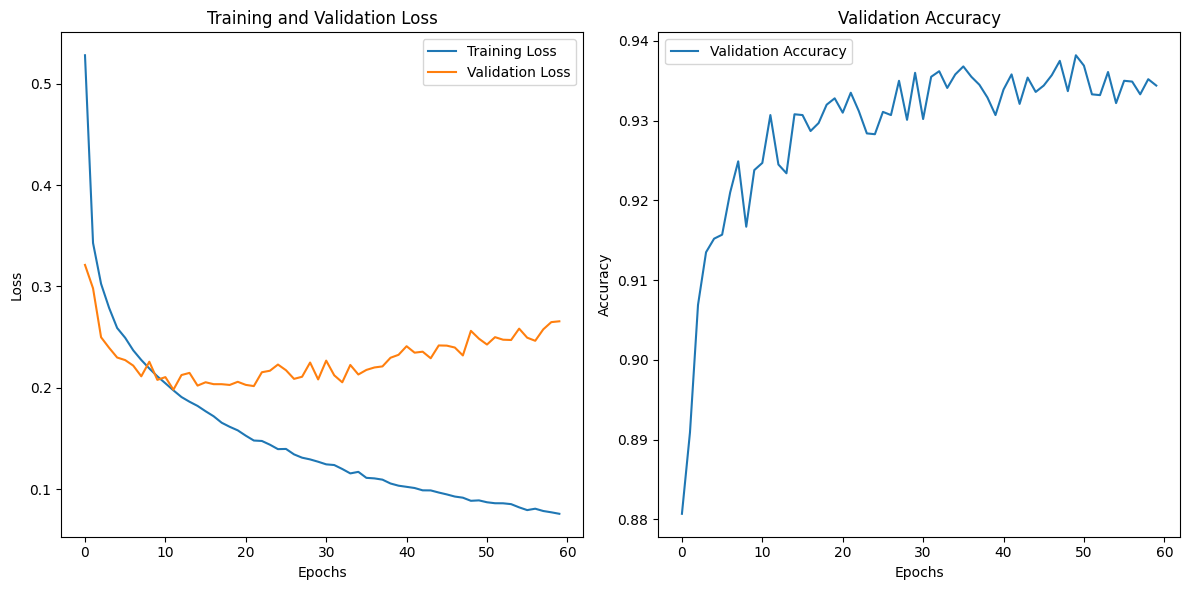

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_loss_epoch, label='Training Loss')
plt.plot(test_loss_epoch, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracy_epoch, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## 2-модель)

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=False)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class MnistModel(nn.Module):
    def __init__(self):
        super(MnistModel, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.layer2 = ResidualBlock(64, 64)
        self.layer3 = ResidualBlock(64, 64)
        self.layer4 = ResidualBlock(64, 128, downsample=nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(128)))
        self.layer5 = ResidualBlock(128, 128)

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(128, 10)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.avg_pool(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

model = MnistModel()

In [ ]:
model.to('cuda')
summary(model,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           3,136
       BatchNorm2d-2           [-1, 64, 14, 14]             128
              ReLU-3           [-1, 64, 14, 14]               0
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5             [-1, 64, 7, 7]          36,864
       BatchNorm2d-6             [-1, 64, 7, 7]             128
              ReLU-7             [-1, 64, 7, 7]               0
            Conv2d-8             [-1, 64, 7, 7]          36,864
       BatchNorm2d-9             [-1, 64, 7, 7]             128
             ReLU-10             [-1, 64, 7, 7]               0
    ResidualBlock-11             [-1, 64, 7, 7]               0
           Conv2d-12             [-1, 64, 7, 7]          36,864
      BatchNorm2d-13             [-1, 64, 7, 7]             128
             ReLU-14             [-1, 6

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
BATCH_SIZE = 100
NUM_EPOCHS = 60

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE)

steps = 0
print_every = 200
train_loss_epoch = []
test_loss_epoch = []
accuracy_epoch = []
preds_hist = []
labels_hist = []

for e in range(NUM_EPOCHS):
    model.train()
    running_loss = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        preds = model(images.to(device))
        loss = loss_fn(preds, labels.to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_train_loss = running_loss / len(train_loader)
    train_loss_epoch.append(epoch_train_loss)

    model.eval()
    running_accuracy = 0
    running_test_loss = 0
    preds_list = []
    with torch.no_grad():
        for images, labels in test_loader:
            preds = model(images.to(device))
            test_loss = loss_fn(preds, labels.to(device))
            running_test_loss += test_loss.item()
            labels_hist.extend(np.squeeze(labels.numpy()))
            ps = torch.exp(preds)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape).to(device)
            preds_list.extend(top_class.cpu().numpy())
            running_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
    preds_hist.extend(np.squeeze(preds_list))
    epoch_test_loss = running_test_loss / len(test_loader)
    epoch_accuracy = running_accuracy / len(test_loader)

    test_loss_epoch.append(epoch_test_loss)
    accuracy_epoch.append(epoch_accuracy)

    print(f"Epoch: {e+1}/{NUM_EPOCHS}.. "
          f"Training Loss: {epoch_train_loss:.3f}.. "
          f"Test Loss: {epoch_test_loss:.3f}.. "
          f"Test Accuracy: {epoch_accuracy:.3f}")
    print(metrics.classification_report(preds_hist,labels_hist))

Epoch: 1/60.. Training Loss: 0.528.. Test Loss: 0.509.. Test Accuracy: 0.814
              precision    recall  f1-score   support

           0       0.90      0.71      0.79      1275
           1       0.97      0.93      0.95      1049
           2       0.85      0.70      0.77      1210
           3       0.82      0.88      0.85       936
           4       0.70      0.79      0.74       880
           5       0.61      0.99      0.75       615
           6       0.45      0.66      0.53       680
           7       0.96      0.72      0.82      1334
           8       0.93      0.97      0.95       959
           9       0.95      0.90      0.92      1062

    accuracy                           0.81     10000
   macro avg       0.81      0.82      0.81     10000
weighted avg       0.84      0.81      0.82     10000

Epoch: 2/60.. Training Loss: 0.382.. Test Loss: 0.385.. Test Accuracy: 0.854
              precision    recall  f1-score   support

           0       0.88      0.7

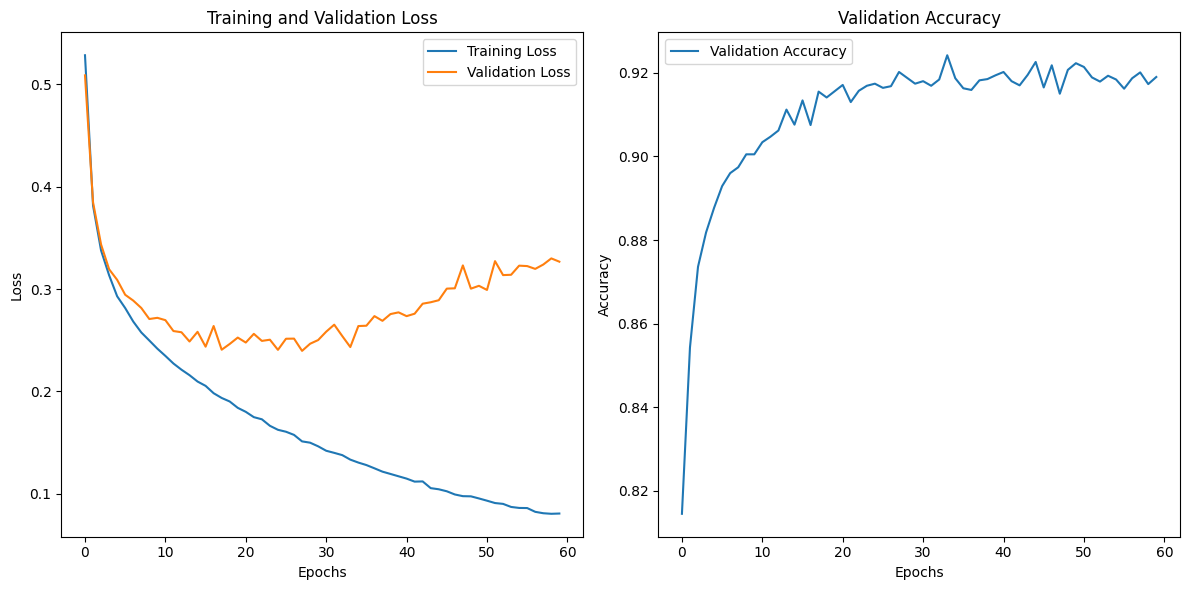

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_loss_epoch, label='Training Loss')
plt.plot(test_loss_epoch, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracy_epoch, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Выводы: я поискал материалы насчет skip-connection в интернете. В частности, о схемах скип-коннекшнов.

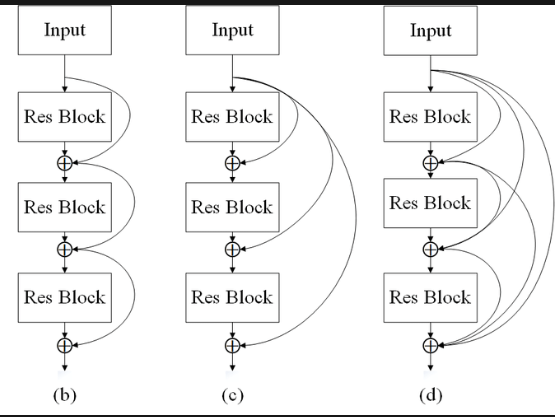

### В своих экспериментах я использовал первый способ применения skip-connection. Также я попробовал использовать skip-connection двумя разными способами. В первом я просто использовал конкатенацию слоев, а во втором использовал класс блока ResidualBlock, похожий на блок из ResNet. В целом, обе модели показали себя хорошо, но первая была чуть лучше, так как, например, метрики f1,recall precision первой модели были равны 0.93, когда у второй они равны 0.91. Также стоит отметить, что обе модели были переобучены. Эту проблему можно решить изменением дропаута. Каких либо изменений в метриках за счет skip-connection я не заметил. Это можно обосновать тем, что skip-connection подходит для более сложных моделей и ее главная цель - "решить проблему деградации точности". То есть, он нужен чтобы акураси не уменьшался после многих эпох. Это видно и на моих графиках, потому что акураси действительно не уменьшался